# Обучение с учителем: качество модели

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и нашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

Для решения задачи необходимо:

* Промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
* Собрать данные по клиентам по следующим группам:
  * Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
  * Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
  * Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
  * Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
* Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
* Включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
* Используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.


### Загрузка данных.

**Описание данных**

В нашем распоряжении четыре файла:

- market_file.csv
- market_money.csv
- market_time.csv
- money.csv

Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:

* `id` — номер покупателя в корпоративной базе данных.
* `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
* `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
* `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
* `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
* `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
* `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
* `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
* `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
* `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Файл `market_money.csv` содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:

* `id` — номер покупателя в корпоративной базе данных.
* `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
* `Выручка` — сумма выручки за период.

Файл `market_time.csv` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

* `id` — номер покупателя в корпоративной базе данных.
* `Период` — название периода, во время которого зафиксировано общее время.
* `минут` — значение времени, проведённого на сайте, в минутах.

Файл `money.csv` содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

* `id` — номер покупателя в корпоративной базе данных.
* `Прибыль` — значение прибыли.

#### Импортируем библиотеки.

In [352]:
pip install phik -q

In [353]:
pip install shap -q

In [354]:
pip install --upgrade scikit-learn -q

In [355]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import math
import shap
import warnings

from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score
)

pd.options.display.float_format = '{:,.3f}'.format
RANDOM_STATE = 42
TEST_SIZE = 0.25
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(12, 6)})

#### Считаем данные датафреймов и запишем в переменные `market_file`, `market_money`, `market_time`, `money`.

In [356]:
market_file = pd.read_csv('/content/drive/MyDrive/DS/Обучение с учителем/market_file.csv', sep = ',', decimal = '.')
market_money = pd.read_csv('/content/drive/MyDrive/DS/Обучение с учителем/market_money.csv', sep = ',', decimal = '.')
market_time = pd.read_csv('/content/drive/MyDrive/DS/Обучение с учителем/market_time.csv', sep = ',')
money = pd.read_csv('/content/drive/MyDrive/DS/Обучение с учителем/money.csv', sep = ';', decimal = ',')

#### Обзор данных `market_file`.

Выведем первые десять строк таблицы на экран.

In [357]:
market_file.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.300,4,762,0.260,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.100,3,431,0.230,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.700,4,284,0.170,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.200,4,192,0.140,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.900,5,154,0.000,Техника для красоты и здоровья,3,3,9,5


Таблица содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

Выведем основную информацию о датафрейме `market_file` с помощью метода `info()`.

In [358]:
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

Таблица содержит 1300 строк, данные предоставлены полностью.

#### Обзор данных `market_money`.

Выведем первые десять строк таблицы на экран.

In [359]:
market_money.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.000
1,215348,текущий_месяц,"3,293.100"
2,215348,предыдущий_месяц,0.000
3,215349,препредыдущий_месяц,"4,472.000"
4,215349,текущий_месяц,"4,971.600"
5,215349,предыдущий_месяц,"5,216.000"
6,215350,препредыдущий_месяц,"4,826.000"
7,215350,текущий_месяц,"5,058.400"
8,215350,предыдущий_месяц,"5,457.500"
9,215351,текущий_месяц,"6,610.400"


Таблица содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

Выведем основную информацию о датафрейме `market_money` с помощью метода `info()`.

In [360]:
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Таблица содержит 3900 строк, данные предоставлены полностью.

#### Обзор данных `market_time`.

Выведем первые десять строк таблицы на экран.

In [361]:
market_time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


Таблица содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.

Выведем основную информацию о датафрейме `market_time` с помощью метода `info()`.

In [362]:
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Таблица содержит 2600 строк, данные предоставлены полностью.

#### Обзор данных `money`.

Выведем первые десять строк таблицы на экран.

In [363]:
money.head(10)

,id,Прибыль
0,215348,0.980
1,215349,4.160
2,215350,3.130
3,215351,4.870
4,215352,4.210
5,215353,3.950
6,215354,3.620
7,215355,5.260
8,215356,4.930
9,215357,4.660


Таблица содержит данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю. Для соблюдения формата, столбец `Прибыль` необходимо умножить на 1000.

Выведем основную информацию о датафрейме `money` с помощью метода `info()`.

In [364]:
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Таблица содержит 2600 строк, данные предоставлены полностью.

#### Выводы.

Данные в таблицах `market_file`, `market_money`, `market_time` и `money` предоставленны полностью. Столбец `Прибыль` необходимо умножить на 1000.

### Предобработка данных.

#### Изменим названия столбцов.

Изменим названия столбцов на строчные буквы

In [365]:
market_file.columns = market_file.columns.str.lower()
market_money.columns = market_money.columns.str.lower()
market_time.columns = market_time.columns.str.lower()
money.columns = money.columns.str.lower()

Уберем пробелы из названий столбцов.

In [366]:
market_file.columns = market_file.columns.str.replace(' ', '_')

#### Изучим пропущенные значения в датафреймах.

In [367]:
market_file.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [368]:
market_money.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [369]:
market_time.isna().sum()

id        0
период    0
минут     0
dtype: int64

In [370]:
money.isna().sum()

id         0
прибыль    0
dtype: int64

Пропусков не обнаружено.

#### Изучим дубликаты в датафреймах.

##### Проверим наличие явных дубликатов.

Проверим наличие дубликатов в таблице `market_file`.

In [371]:
market_file.duplicated().sum()

0

Проверим наличие дубликатов в таблице `market_money`.

In [372]:
market_money.duplicated().sum()

0

Проверим наличие дубликатов в таблице `market_time`.

In [373]:
market_time.duplicated().sum()

0

Проверим наличие дубликатов в таблице `money`.

In [374]:
money.duplicated().sum()

0

Явных дубликатов не обнаружено.

##### Проверим наличие неявных дубликатов.

Проверим неявные дубликаты в таблице `market_file`.

In [375]:
print('покупательская_активность:', market_file['покупательская_активность'].unique())
print('тип_сервиса              :', market_file['тип_сервиса'].unique())
print('разрешить_сообщать       :', market_file['разрешить_сообщать'].unique())
print('популярная_категория     :', market_file['популярная_категория'].unique())

покупательская_активность: ['Снизилась' 'Прежний уровень']
тип_сервиса              : ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать       : ['да' 'нет']
популярная_категория     : ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


В столбце `тип_сервиса` необходимо изменить значение `стандартт` на `стандарт`.

In [376]:
market_file.loc[market_file['тип_сервиса'] == 'стандартт', 'тип_сервиса'] = 'стандарт'

Проверим результат.

In [377]:
market_file['тип_сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Данные успешно изменены.

Проверим неявные дубликаты в таблице `market_money`.

In [378]:
market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Неявные дубликаты не обнаружены.

Проверим неявные дубликаты в таблице `market_time`.

In [379]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

В столбце `период` необходимо изменить значение `предыдцщий_месяц` на `предыдущий_месяц`.

In [380]:
market_time.loc[market_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'

Проверим результат.

In [381]:
market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

Данные успешно изменены.

#### Проверим типы данных с столбцах.

В таблице `money` стобец `прибыль` необходимо умножить на 1000.

In [382]:
money['прибыль'] = money['прибыль'] * 1000

Проверим результат.

In [383]:
money.head(5)

,id,прибыль
0,215348,980.000
1,215349,"4,160.000"
2,215350,"3,130.000"
3,215351,"4,870.000"
4,215352,"4,210.000"


Данные успешно изменены.

#### Проверим количественные значения в таблицах.

Проверим количественные значения в таблице `market_file`.

In [384]:
market_file.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,"1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000","1,300.000"
mean,"215,997.500",4.254,4.012,601.898,0.320,3.270,2.840,4.185,8.177
std,375.422,1.015,0.697,249.856,0.250,1.355,1.971,1.955,3.978
min,"215,348.000",0.900,3.000,110.000,0.000,1.000,0.000,0.000,1.000
25%,"215,672.750",3.700,4.000,405.500,0.170,2.000,1.000,3.000,5.000
50%,"215,997.500",4.200,4.000,606.000,0.240,3.000,3.000,4.000,8.000
75%,"216,322.250",4.900,4.000,806.000,0.300,4.000,4.000,6.000,11.000
max,"216,647.000",6.600,5.000,"1,079.000",0.990,6.000,10.000,9.000,20.000


Данные выглядят нормально, выбросов не обнаружено.

Проверим количественные значения в таблице `market_money`.

In [385]:
market_money.describe()

,id,выручка
count,"3,900.000","3,900.000"
mean,"215,997.500","5,025.696"
std,375.326,"1,777.704"
min,"215,348.000",0.000
25%,"215,672.750","4,590.150"
50%,"215,997.500","4,957.500"
75%,"216,322.250","5,363.000"
max,"216,647.000","106,862.200"


Проверим значения выручки выше 10000.

In [386]:
market_money[market_money['выручка'] > 10000]

,id,период,выручка
98,215380,текущий_месяц,"106,862.200"


Клиент с выручкой 106,862 сильно выбивается из остальных значений, удалим его из всех таблиц.

In [387]:
market_file = market_file[market_file['id'] != 215380]
market_money = market_money[market_money['id'] != 215380]
market_time = market_time[market_time['id'] != 215380]
money = money[money['id'] != 215380]

Проверим результат.

In [388]:
market_money[market_money['выручка'] > 10000]

,id,период,выручка


Клиент успешно удален.

Проверим количественные значения в таблице `market_time`.

In [389]:
market_time.describe()

,id,минут
count,"2,598.000","2,598.000"
mean,"215,997.975",13.336
std,375.103,4.082
min,"215,348.000",4.000
25%,"215,673.250",10.000
50%,"215,998.000",13.000
75%,"216,322.750",16.000
max,"216,647.000",23.000


Данные выглядят нормально, выбросов не обнаружено.

Проверим количественные значения в таблице `money`.

In [390]:
money.describe()

,id,прибыль
count,"1,299.000","1,299.000"
mean,"215,997.975","3,996.721"
std,375.175,"1,014.107"
min,"215,348.000",860.000
25%,"215,673.500","3,300.000"
50%,"215,998.000","4,050.000"
75%,"216,322.500","4,670.000"
max,"216,647.000","7,430.000"


Данные выглядят нормально, выбросов не обнаружено.

#### Выводы.

При изучении общей информации были выявлены и обработанны следующие данные:

- переименованы столбцы в таблицах `market_file`, `market_money`, `market_time`, `money`
- изучены пропущенные значения в таблицах `market_file`, `market_money`, `market_time`, `money`
- обработаны явные дубликаты в таблицах `market_file`, `market_money`, `market_time`, `money`
- выявлены и обработаны неявные дубликаты в таблице `market_file`
- изменены типы данных в таблицах `market_file`, `market_money`, `money`
- проверены количественные значения в таблицах `market_file`, `market_money`, `market_time`, `money`
- удален выброс в таблицах `market_file`, `market_money`, `market_time`, `money`

Данные в таблицах были предоставленны полностью, пропусков не обнаружено. Явных дубликатов не обнаружено, были выявлены и обработаны неявные дубликаты в таблице `market_file`. В таблицах `market_file`, `market_money`, `money` типы данных были приведены в соответствии значениям. Были проверены количественные значения в таблицах `market_file`, `market_money`, `market_time`, `money`. В таблице `market_money` был найден и удален выброс в столбце `выручка` со значением 106,862. Остальные данные выглядят нормально.

### Исследовательский анализ данных.

Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Удалим данных клиентов из всех таблиц.

In [391]:
for i in market_money[market_money['выручка'] == 0]['id'].unique().tolist():
    market_file = market_file[market_file['id'] != i]
    market_money = market_money[market_money['id'] != i]
    market_time = market_time[market_time['id'] != i]
    money = money[money['id'] != i]

Проверим результат.

In [392]:
market_money[market_money['выручка'] == 0]

,id,период,выручка


Клиенты успешно удалены.

Напишем функцию для проверки количественных значений.

In [393]:
def check_quan(data, col, bins):
    display(data[col].describe())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

    data[col].plot(kind='hist', bins=bins, ax=axes[0], grid=True)
    axes[0].set_title('Гистограмма распределения', fontsize=14)
    axes[0].set_ylabel('Частота встречаемости')
    axes[0].set_xlabel('Наблюдаемые значения')

    data[col].plot(kind='box', ax=axes[1], rot=0, grid=True)
    axes[1].set_title('Разброс значений признаков', fontsize=14)
    axes[1].set_xlabel('Категория')
    axes[1].set_ylabel('Наблюдаемые значения')
    plt.show()

Напишем функцию для проверки категориальных значений.

In [394]:
def chek_cat(data, col, title, rot=0, nrows=1, ncols=2, figsize=(12,6)):
    cat = data.pivot_table(index=col, values='id', aggfunc='count').sort_values('id', ascending=False)
    display(cat)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.tight_layout(h_pad=10)

    cat.plot(kind='bar', ax=axes[0], grid=True, rot=rot, legend=False)
    axes[0].set_title(title, fontsize=14)
    axes[0].set_ylabel('Количество значений')
    axes[0].set_xlabel(col)

    cat['id'].plot(kind='pie', ax=axes[1], autopct='%1.2f%%', label='')
    axes[1].set_title('Процентное соотношение', fontsize=14)

    plt.show()

#### Исследовательский анализ данных таблицы `market_file`.

**Изучим количественные признаки.**

Построим гистограмму распределения по признаку `маркет_актив_6_мес`.

count   1,296.000
mean        4.256
std         1.014
min         0.900
25%         3.700
50%         4.200
75%         4.900
max         6.600
Name: маркет_актив_6_мес, dtype: float64

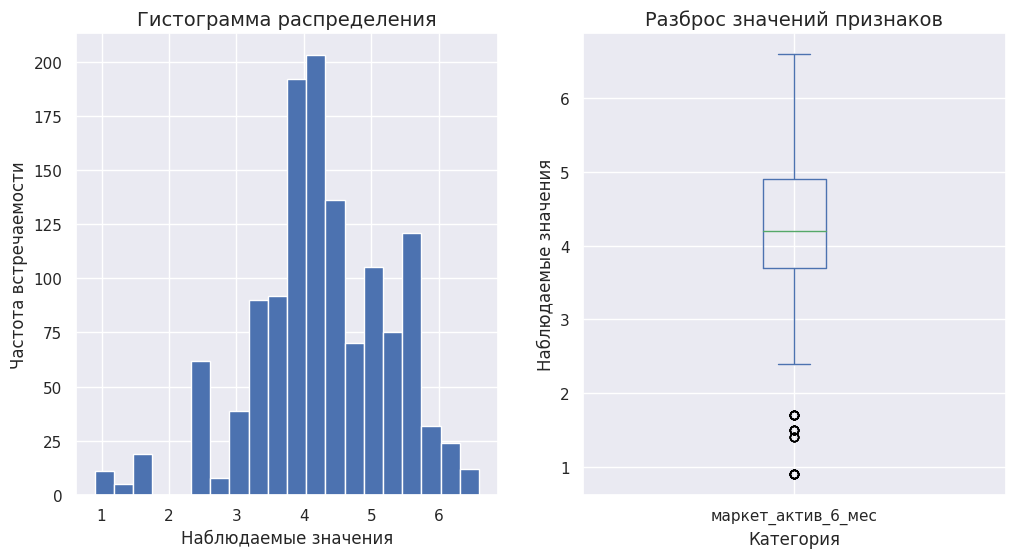

In [395]:
check_quan(market_file, 'маркет_актив_6_мес', 20)

На графике мы видим нормальное распределение. Разброс значений от 0.9 до 6.6. Есть небольшая группа клиентов с низкой маркетинговой активностью, меньше двух.

Построим гистограмму распределения по признаку `маркет_актив_тек_мес`.

count   1,296.000
mean        4.009
std         0.696
min         3.000
25%         4.000
50%         4.000
75%         4.000
max         5.000
Name: маркет_актив_тек_мес, dtype: float64

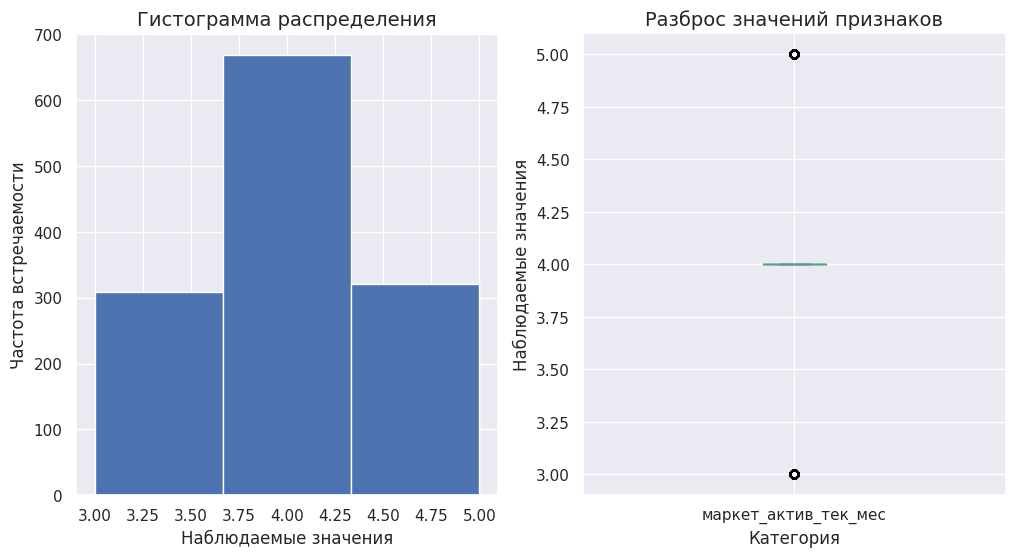

In [396]:
check_quan(market_file, 'маркет_актив_тек_мес', 3)

На графике мы видим нормальное распределение. Разброс значений от 3 до 5.

Построим гистограмму распределения по признаку `длительность`.

count   1,296.000
mean      602.968
std       249.196
min       121.000
25%       409.500
50%       606.500
75%       806.250
max     1,079.000
Name: длительность, dtype: float64

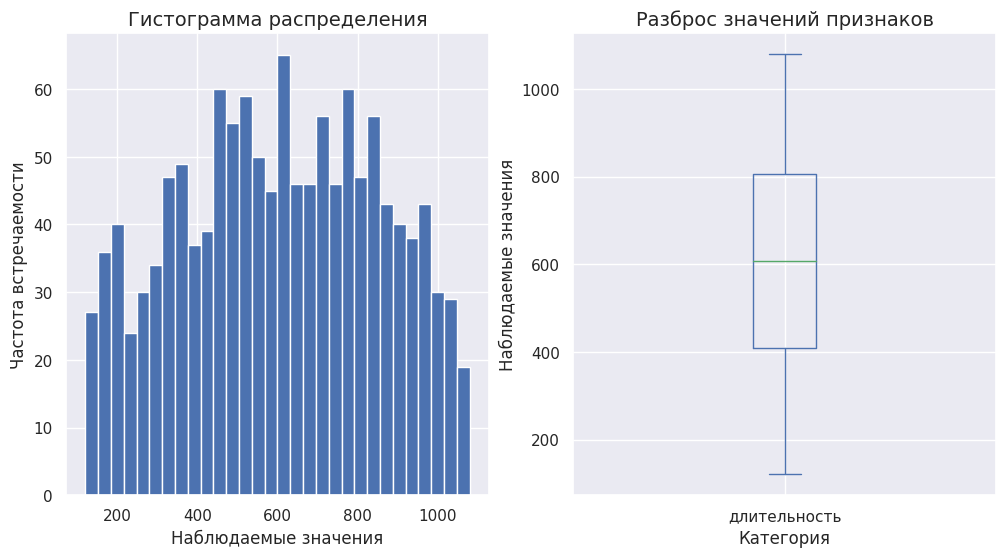

In [397]:
check_quan(market_file, 'длительность', 30)

На графике мы видим нормальное распределение. Разброс значений от 121 до 1079. Выбросов не обнаружено.

Построим гистограмму распределения по признаку `акционные_покупки`.

count   1,296.000
mean        0.320
std         0.249
min         0.110
25%         0.170
50%         0.240
75%         0.300
max         0.990
Name: акционные_покупки, dtype: float64

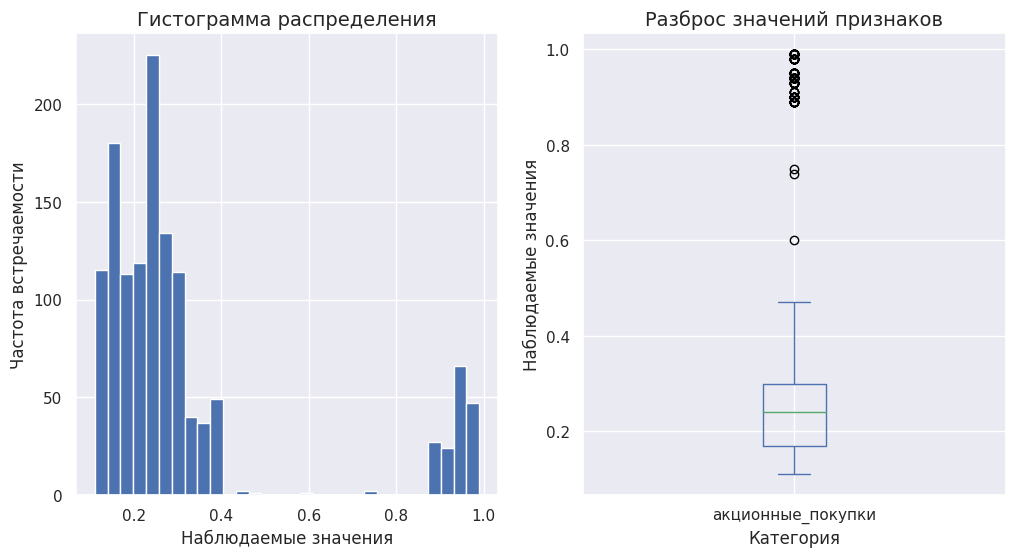

In [398]:
check_quan(market_file, 'акционные_покупки', 30)

Распределения деляться на 2 кластера. Основная доля покупок по акциям лежит в значениях от 11% до 40%. Есть группа клиентов, у которых 90% покупок состоят только из акционных товаров. Возможно стоит разделить клиентов на категории, с акционными покупками до 50% и более 50%.

Построим гистограмму распределения по признаку `средний_просмотр_категорий_за_визит`.

count   1,296.000
mean        3.268
std         1.355
min         1.000
25%         2.000
50%         3.000
75%         4.000
max         6.000
Name: средний_просмотр_категорий_за_визит, dtype: float64

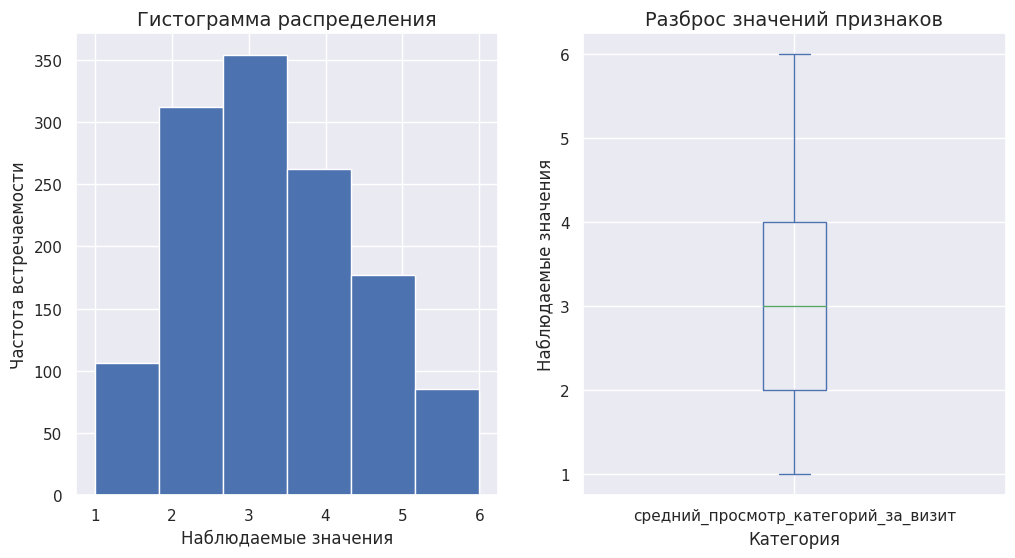

In [399]:
check_quan(market_file, 'средний_просмотр_категорий_за_визит', 6)

На графике мы видим нормальное распределение. Разброс значений от 1 до 6. Выбросов не обнаружено.

Построим гистограмму распределения по признаку `неоплаченные_продукты_штук_квартал`.

count   1,296.000
mean        2.842
std         1.974
min         0.000
25%         1.000
50%         3.000
75%         4.000
max        10.000
Name: неоплаченные_продукты_штук_квартал, dtype: float64

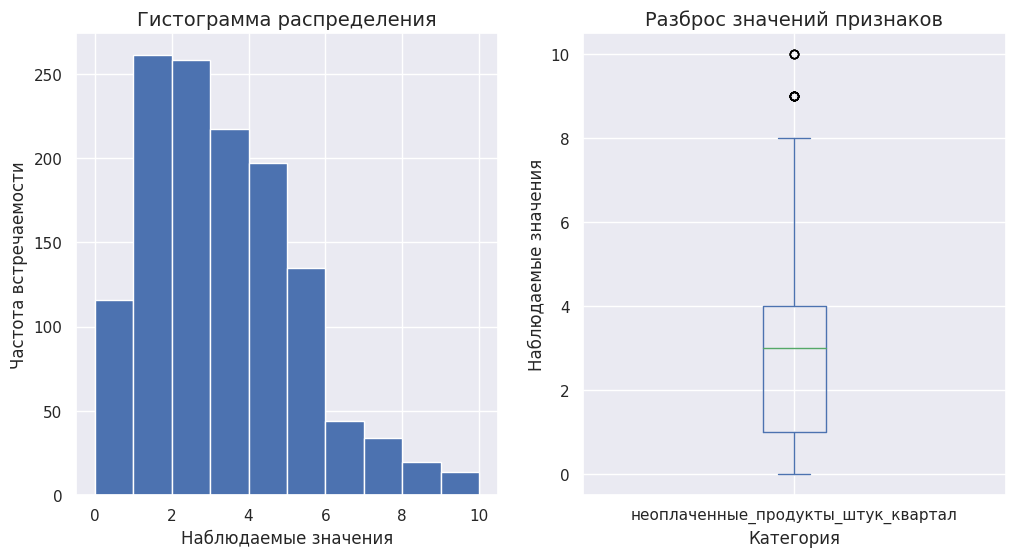

In [400]:
check_quan(market_file, 'неоплаченные_продукты_штук_квартал', 10)

На графике мы видим нормальное распределение. Разброс значений от 0 до 10. Выбросов не обнаружено.

Построим гистограмму распределения по признаку `ошибка_сервиса`.

count   1,296.000
mean        4.184
std         1.952
min         0.000
25%         3.000
50%         4.000
75%         6.000
max         9.000
Name: ошибка_сервиса, dtype: float64

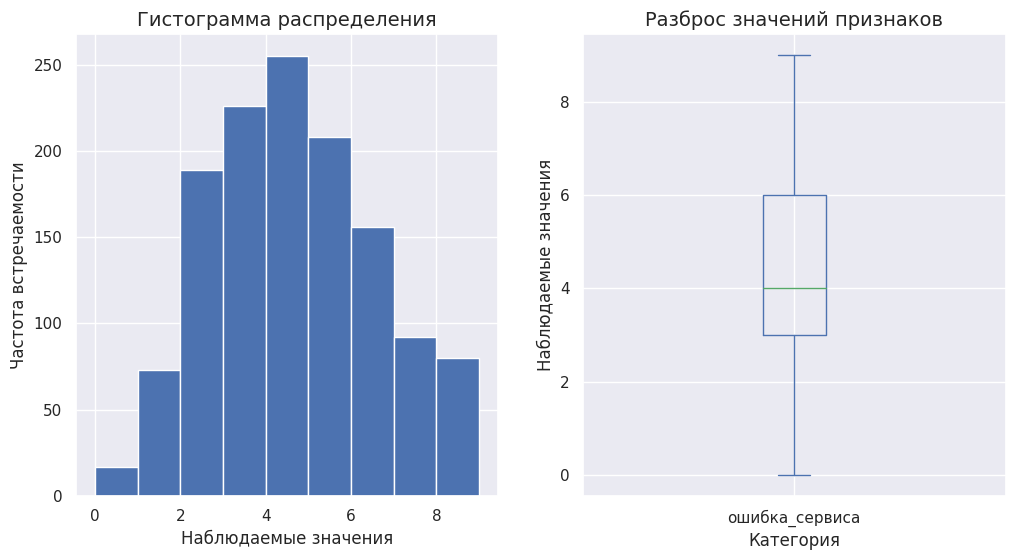

In [401]:
check_quan(market_file, 'ошибка_сервиса', 9)

На графике мы видим нормальное распределение. Разброс значений от 0 до 9. Выбросов не обнаружено.

Построим гистограмму распределения по признаку `страниц_за_визит`.

count   1,296.000
mean        8.188
std         3.978
min         1.000
25%         5.000
50%         8.000
75%        11.000
max        20.000
Name: страниц_за_визит, dtype: float64

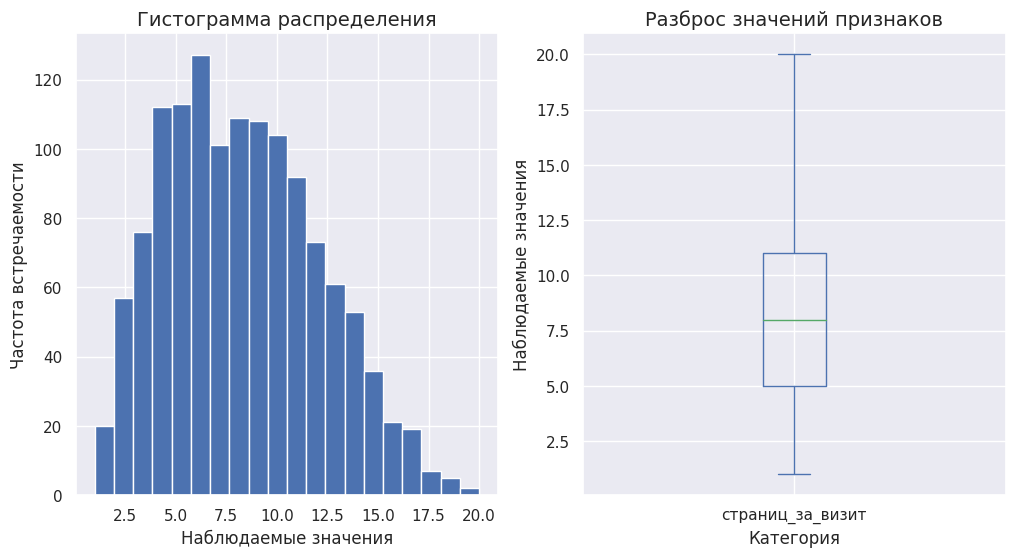

In [402]:
check_quan(market_file, 'страниц_за_визит', 20)

На графике мы видим нормальное распределение. Разброс значений от 1 до 20. Выбросов не обнаружено.

**Изучим категориальные признаки.**

In [403]:
market_file.head(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4


Построим график по признаку `покупательская_активность`.

,id
покупательская_активность,
Прежний уровень,802
Снизилась,494


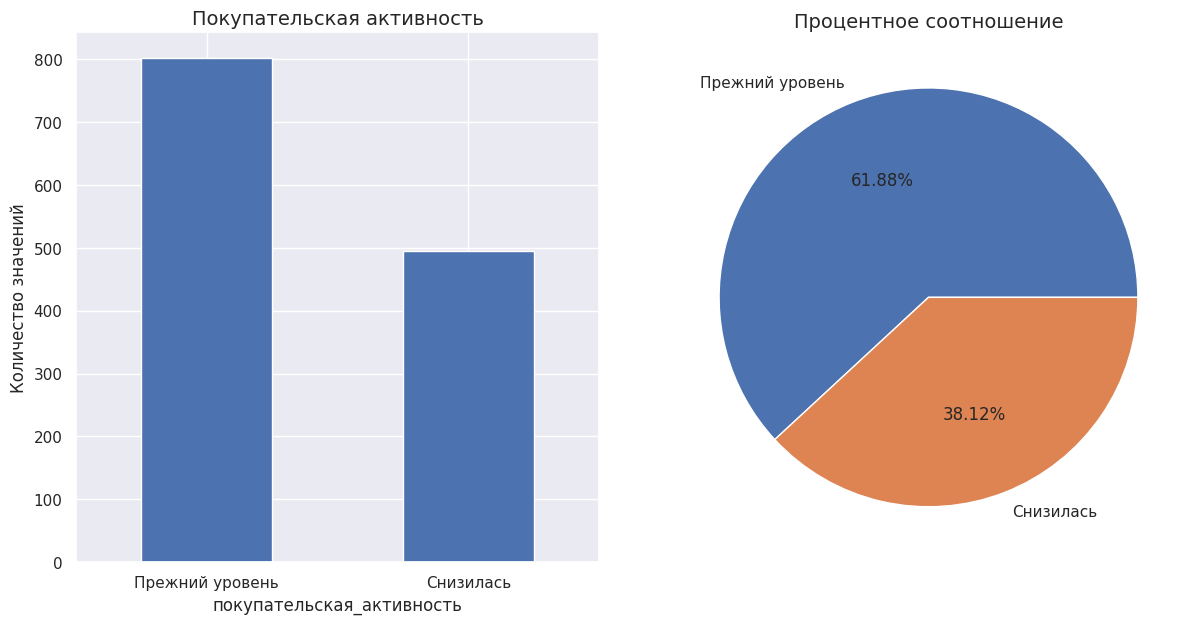

In [404]:
chek_cat(market_file, 'покупательская_активность', 'Покупательская активность')

Покупательская активность является целевым признаком. Значений `Прежний уровень` примерно 62%, `Снизилась` примерно 38%. Первый признак выше, но не критично.

Построим график по признаку `тип_сервиса`.

,id
тип_сервиса,
стандарт,922
премиум,374


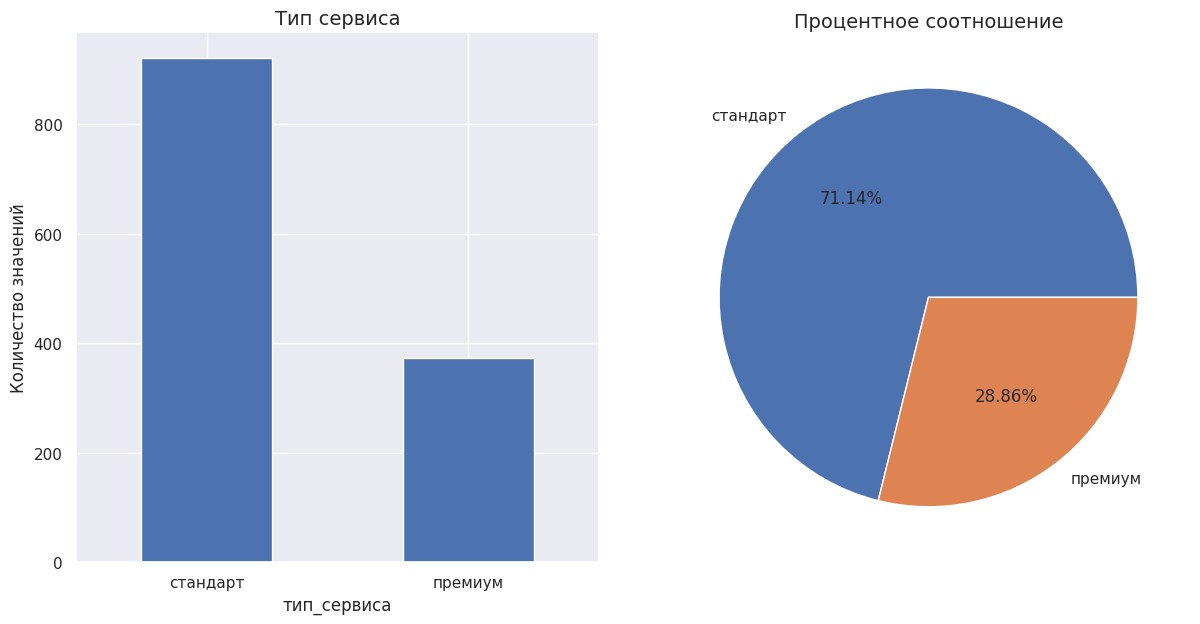

In [405]:
chek_cat(market_file, 'тип_сервиса', 'Тип сервиса')

Больше пользователей с типом сервиса `стандарт` - 922, `премиум` - 374.

Построим график по признаку `разрешить_сообщать`.

,id
разрешить_сообщать,
да,959
нет,337


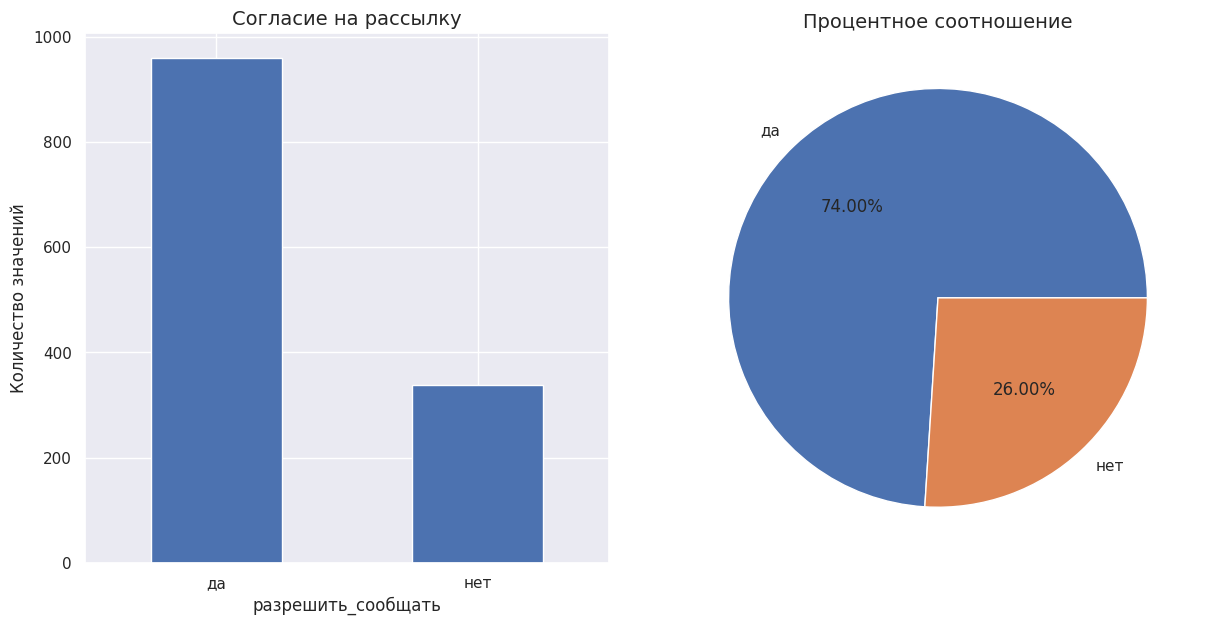

In [406]:
chek_cat(market_file, 'разрешить_сообщать', 'Согласие на рассылку')

Большинство клиентов дали согласие на рассылку - 74% согласны, 26% отказались.

Построим график по признаку `популярная_категория`.

,id
популярная_категория,
Товары для детей,329
Домашний текстиль,250
Косметика и аксесуары,223
Техника для красоты и здоровья,182
Мелкая бытовая техника и электроника,174
Кухонная посуда,138


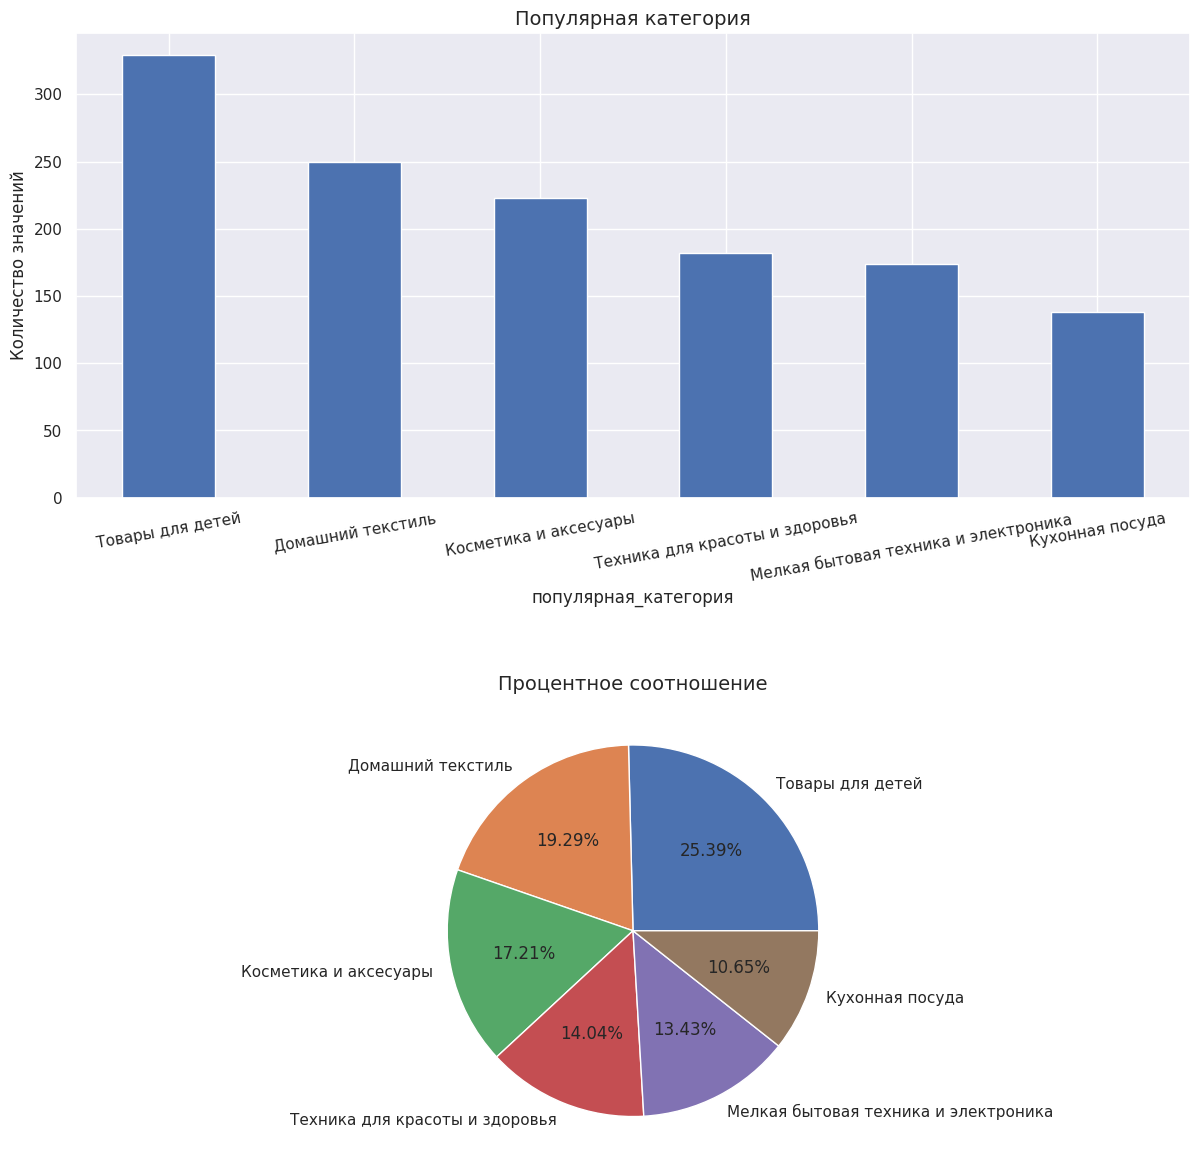

In [407]:
chek_cat(market_file, 'популярная_категория', 'Популярная категория', rot=10, nrows=2, ncols=1, figsize=(12, 12))

Наиболее популярная категория `Товары для детей`, заетм `Домашний текстиль` и `Косметика и аксесуары`. `Кухонная посуда` является наименее популярной категорией.

#### Исследовательский анализ данных таблицы `market_money`.

In [408]:
market_money.head(3)

,id,период,выручка
3,215349,препредыдущий_месяц,"4,472.000"
4,215349,текущий_месяц,"4,971.600"
5,215349,предыдущий_месяц,"5,216.000"


count   3,888.000
mean    5,007.256
std       679.193
min     2,758.700
25%     4,591.950
50%     4,959.000
75%     5,363.000
max     7,799.400
Name: выручка, dtype: float64

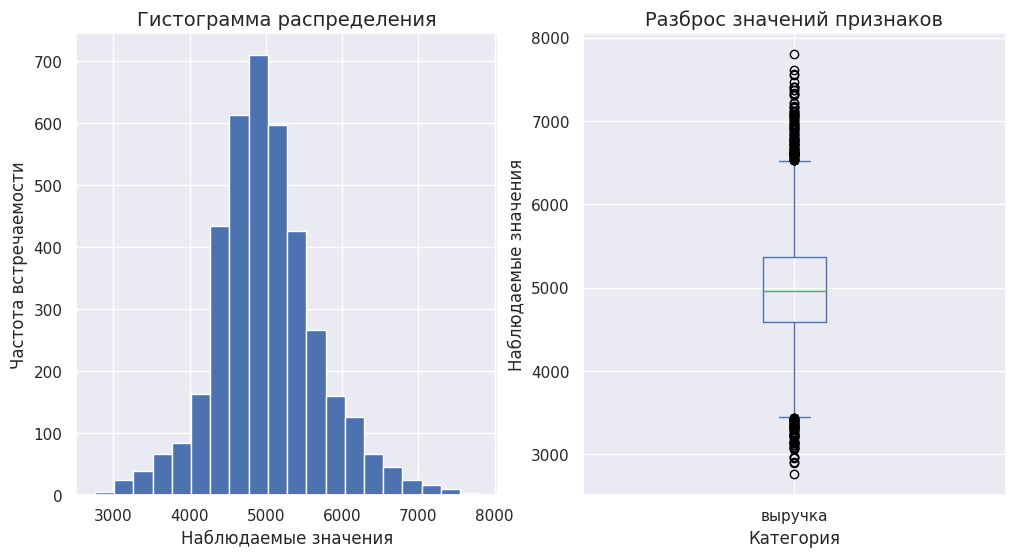

In [409]:
check_quan(market_money, 'выручка', 20)

На графике мы видим нормальное распределение. Разброс значений от 2758 до 7799. Выбросов не обнаружено.

#### Исследовательский анализ данных таблицы `market_time`.

In [410]:
market_time.head(3)

,id,период,минут
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


count   2,592.000
mean       13.341
std         4.083
min         4.000
25%        10.000
50%        13.000
75%        16.000
max        23.000
Name: минут, dtype: float64

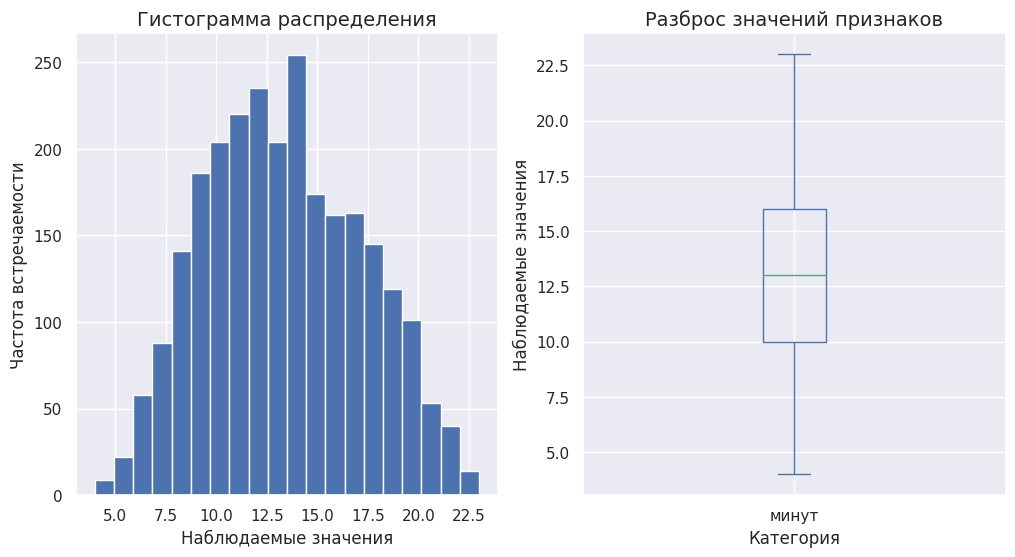

In [411]:
check_quan(market_time, 'минут', 20)

На графике мы видим нормальное распределение. Разброс значений от 4 до 23. Выбросов не обнаружено.

#### Исследовательский анализ данных таблицы `money`.

In [412]:
money.head(3)

,id,прибыль
1,215349,"4,160.000"
2,215350,"3,130.000"
3,215351,"4,870.000"


count   1,296.000
mean    3,997.701
std     1,011.198
min       860.000
25%     3,300.000
50%     4,045.000
75%     4,670.000
max     7,430.000
Name: прибыль, dtype: float64

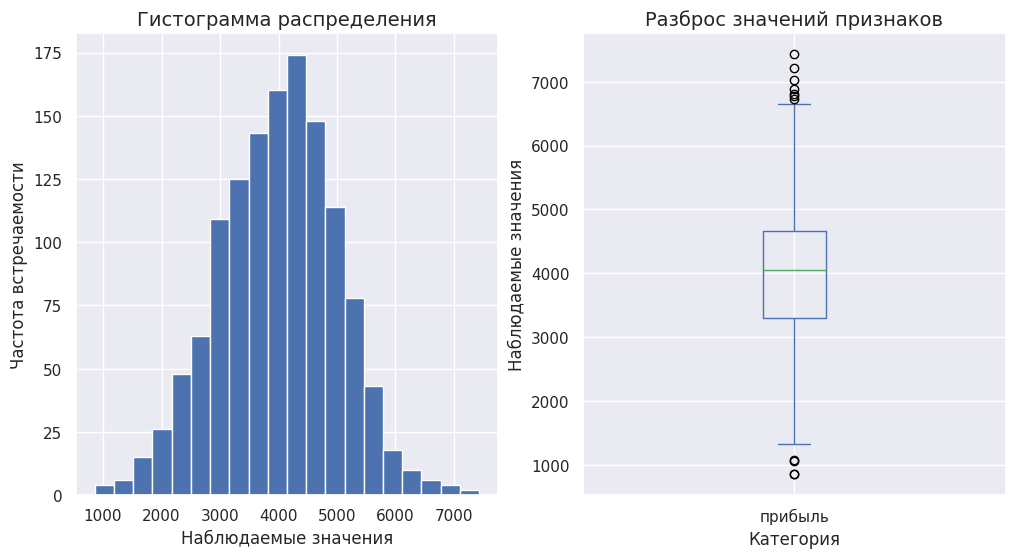

In [413]:
check_quan(money, 'прибыль', 20)

На графике мы видим нормальное распределение. Разброс значений от 860 до 7430. Выбросов не обнаружено.

#### Выводы.

В таблице `market_file` данные количественных признаков распределены нормально, выбросов обнаружено не было. Была вявлена небольшая группа клиентов с низкой маркетинговой активностью, меньше двух.  Распределение признака `акционные_покупки` деляться на 2 кластера. Основная доля покупок по акциям лежит в значениях от 11% до 40%. Есть группа клиентов, у которых 90% покупок состоят только из акционных товаров. Возможно стоит разделить клиентов на категории, с акционными покупками до 50% и более 50%.

Целевым признаком является `покупательская_активность`. Значений `Прежний уровень` примерно 62%, `Снизилась` примерно 38%. Первый признак выше, но не критично.

Больше пользователей с типом сервиса `стандарт` - 922, `премиум` - 374.

Большинство клиентов дали согласие на рассылку - 74% согласны, 26% отказались.

Наиболее популярная категория `Товары для детей`, заетм `Домашний текстиль` и `Косметика и аксесуары`. `Кухонная посуда` является наименее популярной категорией.

Данные в таблице `market_money`распределены нормально, выбросов не обнаружено. Разброс значений признака `выручка` - от 2758 до 7799.

Данные в таблице `market_time` распределены нормально. Разброс значений от 4 до 23. Выбросов не обнаружено.

Данные в таблице `money` также аспределены нормально. Разброс значений от 860 до 7430. Выбросов не обнаружено.

### Объединение таблиц.

Для объединения таблиц необходимо изменить таблицы `market_money` и `market_time`, создадим сводные таблицы.

Для начала проверим размерность таблицы `market_file`.

In [414]:
market_file.shape

(1296, 13)

В таблице `market_file` данные о 1296 пользователях, 13 столбцов.

Создаем сводную таблицу `market_money_pivot`.

In [415]:
market_money_pivot = market_money.pivot_table(
    index=['id'],
    columns='период',
    values='выручка',
    fill_value=0
)

Проверим результат.

In [416]:
market_money_pivot.head(3)

период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,"5,216.000",4472,"4,971.600"
215350,"5,457.500",4826,"5,058.400"
215351,"6,158.000",4793,"6,610.400"


Изменим названия столбцов.

In [417]:
market_money_pivot.columns = ['выручка_предыдущий_месяц',
                              'выручка_препредыдущий_месяц',
                              'выручка_текущий_месяц']

Проверим размерность.

In [418]:
market_money_pivot.shape

(1296, 3)

Данные по всем пользователям на месте. В таблице 3 столбца.

Создаем сводную таблицу `market_time_pivot`.

In [419]:
market_time_pivot = market_time.pivot_table(index=['id'] ,columns='период', values='минут')

Проверим результат.

In [420]:
market_time_pivot.head(3)

период,предыдущий_месяц,текущий_месяц
id,,
215349,12,10
215350,8,13
215351,11,13


Изменим названия столбцов.

In [421]:
market_time_pivot.columns = ['время_предыдущий_месяц', 'время_текущий_месяц']

Проверим размерность.

In [422]:
market_time_pivot.shape

(1296, 2)

Данные по всем пользователям на месте. В таблице 2 столбца.

Объеденим таблицу `market_file` и `market_money_pivot`.

In [423]:
data_full = market_file.join(market_money_pivot, on='id', how='right')

Объеденим таблицу `data_full` и `market_time_pivot`.

In [424]:
data_full = data_full.join(market_time_pivot, on='id', how='right')

**Итоговая таблица.**

In [425]:
data_full.head(5)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5,"5,216.000",4472,"4,971.600",12,10
2,215350,Снизилась,стандарт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,"5,457.500",4826,"5,058.400",8,13
3,215351,Снизилась,стандарт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4,"6,158.000",4793,"6,610.400",11,13
4,215352,Снизилась,стандарт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2,"5,807.500",4594,"5,872.500",8,11
5,215353,Снизилась,стандарт,да,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,"4,738.500",5124,"5,388.500",10,10


In [426]:
data_full.shape

(1296, 18)

В таблице 1296 строк и 18 столбцов, все данные на месте.

 ### Корреляционный анализ.

Построим матрицу корреляции $\phi_K$.

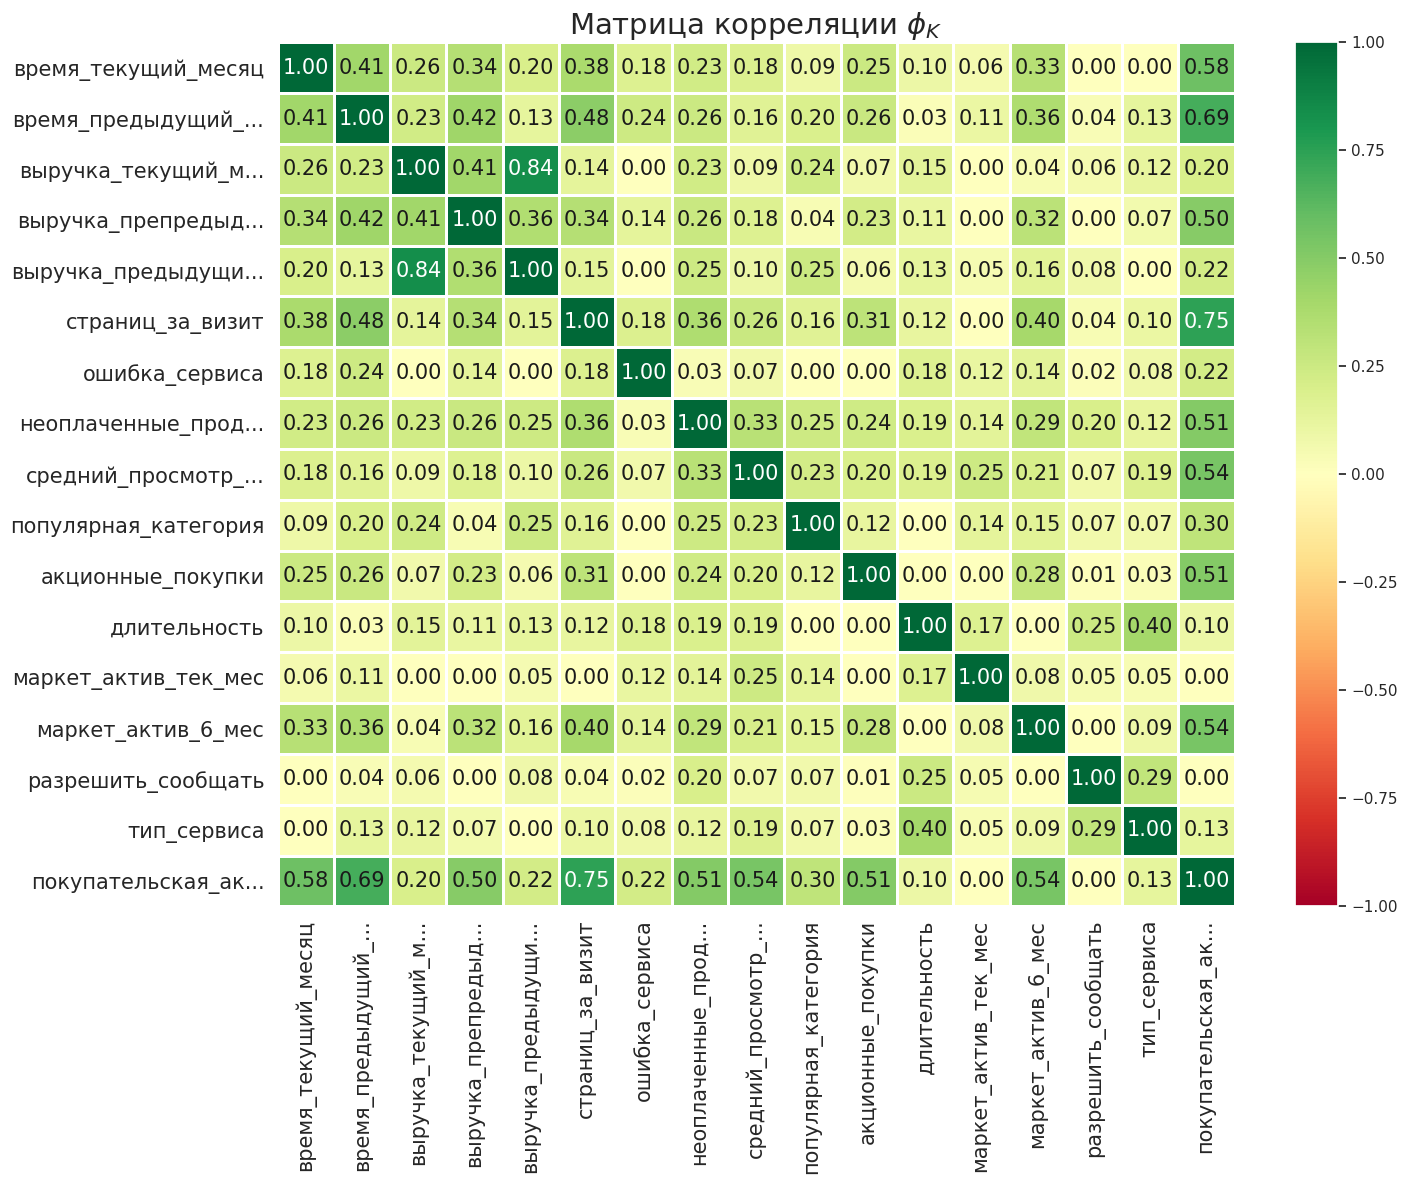

In [427]:
interval_cols = ['маркет_актив_6_мес',
                 'маркет_актив_тек_мес',
                 'длительность',
                 'акционные_покупки',
                 'средний_просмотр_категорий_за_визит',
                 'неоплаченные_продукты_штук_квартал',
                 'ошибка_сервиса',
                 'страниц_за_визит',
                 'выручка_предыдущий_месяц',
                 'выручка_препредыдущий_месяц',
                 'выручка_текущий_месяц',
                 'время_предыдущий_месяц',
                 'время_текущий_месяц'
                ]

phik_overview = data_full.drop(['id'], axis=1).phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"Матрица корреляции $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

На матрице мы видим, что `Покупательская активность` коррелирует со всеми признаками, кроме `маркет_актив_тек_мес` и `разрешить_сообщать`.

Корреляция между признаками недостатачно высокая, чтобы говорить о мультиколлинеарности.

### Использование пайплайнов.

Создадим столбец с бинарным целевым признаком, где 1 - активность снизилась, 0 - остался прежний уровень.

In [428]:
data_full['покупательская_активность_01'] = \
data_full['покупательская_активность'].apply(lambda x: 1 if x=='Снизилась' else 0)

In [429]:
data_full.sample(3)

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,покупательская_активность_01
119,215467,Снизилась,стандарт,да,4.400,4,503,0.900,Мелкая бытовая техника и электроника,2,3,3,3,"4,853.000",4367,"5,062.300",7,13,1
847,216195,Прежний уровень,стандарт,да,5.800,4,732,0.110,Косметика и аксесуары,5,1,4,9,"5,113.000",5392,"5,001.200",11,20,0
803,216151,Прежний уровень,премиум,нет,2.600,4,708,0.130,Товары для детей,2,5,5,14,"5,736.000",5241,"5,437.000",14,13,0


Поделим данные на тренировочную и тестовую выборку.

In [430]:
X_train, X_test, y_train, y_test = train_test_split(
    data_full.drop(['id',
                    'покупательская_активность',
                    'покупательская_активность_01'], axis=1),
    data_full['покупательская_активность_01'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = data_full['покупательская_активность_01']
)

Создадим списки с названиями признаков.

In [431]:
ohe_columns = ['популярная_категория', 'разрешить_сообщать']

ord_columns = ['тип_сервиса']

num_columns = X_train.select_dtypes(include='number').columns.tolist()

Добавляем ohe-кодирование в пайплайн.

In [432]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        )
    ]
)

Добавляем ord-кодирование в пайплайн.

In [433]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


Напишем код для пайплайна подготовки данных.

In [434]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

Создаем итоговый пайплайн.

In [435]:
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

Укажем модели и гиперпараметры.

In [436]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.01, 0.1, 1, 5],
        'models__gamma': [0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    }
]


Применим метод GridSearchCV для поиска лучшей модели.

In [437]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [438]:
grid.fit(X_train, y_train);

Выведем на экран лучшую модель, ее параметры и кодировщик.

In [439]:
print('Лучшая модель и её параметры:\n\n', grid.best_params_)

Лучшая модель и её параметры:

 {'models': SVC(probability=True, random_state=42), 'models__C': 0.1, 'models__gamma': 0.1, 'preprocessor__num': StandardScaler()}


Выведем на экран метрику лучшей модели на кросс-валидационной выборке.

In [440]:
print ('Метрика лучшей модели на кросс-валидационной выборке:', grid.best_score_)

Метрика лучшей модели на кросс-валидационной выборке: 0.9121031072394707


Выведем на экран метрику лучшей модели на тестовой выборке.

In [441]:
y_pred = grid.predict_proba(X_test)[:,1]
print(f'Площадь ROC-кривой: {roc_auc_score(y_test, y_pred)}')

Площадь ROC-кривой: 0.911175828176192


In [442]:
probabilities = grid.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.911175828176192


#### Выводы.

Лучшая модель - SVC, с параметрами C=0.1, gamma=0.1, с кодировщиком StandardScaler.

Метрика roc_auc лучшей модели на кросс-валидационной и тестовой выборке составила 0.91. ROC-AUC оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения.

### Анализ важности признаков.

Выбираем лучшую модель.

In [443]:
best_model = grid.best_estimator_.named_steps['models']

Выбираем лучший кодировщик.

In [444]:
preprocessor = grid.best_estimator_.named_steps['preprocessor']

Кодируем тренировчную и тестовую выборки.

In [445]:
X_train_p = preprocessor.transform(X_train)
X_test_p = preprocessor.transform(X_test)

Получаем названия столбцов.

In [446]:
feature_names = preprocessor.get_feature_names_out().tolist()

Используем SHAP.

In [447]:
explainer = shap.Explainer(best_model.predict_proba, X_train_p)
shap_values = explainer(X_test_p)

PermutationExplainer explainer: 325it [09:19,  1.75s/it]


Строим график значимости признаков.

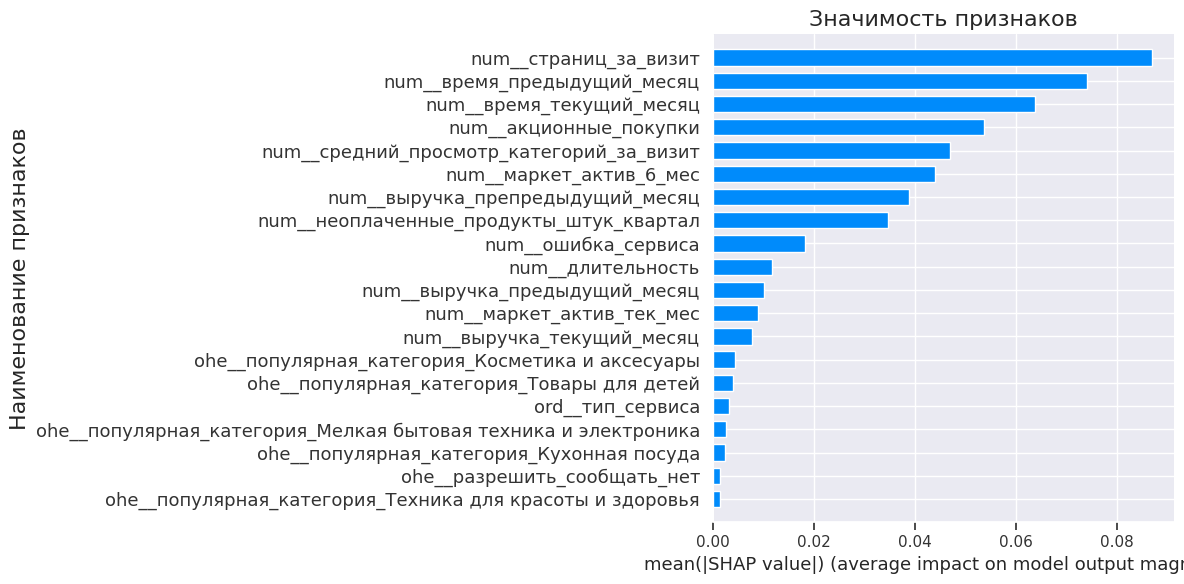

In [448]:
plt.title('Значимость признаков', fontsize=16)
plt.ylabel('Наименование признаков', fontsize=16)

shap.summary_plot(shap_values[:,:,1],
                  X_test_p,
                  feature_names=feature_names,
                  plot_type='bar',
                  plot_size=(12,6)
                 )

#### Выводы.

Наиболее важные признаки: `страниц_за_визит`, `время_предыдущий_месяц`, `время_текущий_месяц`, `акционные_покупки` и `средний_просмотр_категорий_за_визит`.

Мало важные признаки: `популярная_категория_Техника для красоты и здоровья`, `разрешить_сообщать_нет`, `популярная_категория_Кухонная посуда`, `популярная_категория_Мелкая бытовая техника и электроника` и `тип_сервиса`.

Категории товаров оказались не столь важны. На покупательскую активность больше влияет количество просмотренных страниц, время проведенное на сайте и акционные покупки. Исходя из данных наблюдений, можно сделать вывод, что нужно создавать условия на сайте для максимально комфортного просмотра товаров и следить за наличием акций.

### Сегментация покупателей.

Добавим в таблицу `X_test` предсказанные значения.

In [449]:
X_test['покупательская_активность_01'] = grid.predict(X_test)
X_test['покупательская_активность'] = \
X_test['покупательская_активность_01'].apply(lambda x: 'Снизилась' if x==1 else 'Прежний уровень')

Добавим стольбец `вероятнось` с вероятностью снижения покупательской активности.

In [450]:
X_test['вероятность'] = grid.predict_proba(X_test)[:,1]

Объеденим таблицу `X_test` и `id` из таблицы `data_full` по индексам.

In [451]:
X_test = X_test.merge(data_full['id'], left_index=True, right_index=True)

Объеденим таблицу `X_test` и `money` по `id`.

In [452]:
X_test = X_test.merge(money, on='id', how='inner')

Проверим результат.

In [453]:
X_test.sample(5)

,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,...,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,покупательская_активность_01,покупательская_активность,вероятность,id,прибыль
24,стандарт,да,6.600,3,839,0.240,Косметика и аксесуары,3,3,4,...,"4,830.000",4779,"4,915.800",14,11,0,Прежний уровень,0.080,215907,"3,770.000"
211,стандарт,да,4.300,4,404,0.230,Кухонная посуда,4,2,5,...,"4,668.500",5105,"4,420.200",20,18,0,Прежний уровень,0.014,216473,"4,250.000"
64,стандарт,да,5.200,5,373,0.140,Домашний текстиль,1,4,3,...,"4,751.000",5102,"4,576.800",13,14,0,Прежний уровень,0.357,215906,"3,360.000"
228,стандарт,нет,4.400,3,206,0.290,Товары для детей,4,4,6,...,"4,381.000",4831,"4,901.000",12,17,0,Прежний уровень,0.086,216212,"4,260.000"
4,стандарт,нет,5.500,4,147,0.990,Мелкая бытовая техника и электроника,1,2,3,...,"5,090.000",4451,"5,773.800",15,18,0,Прежний уровень,0.593,215934,"4,400.000"


Построим диаграмму рассеяния по признакам `прибыль` и `акционные_покупки`.

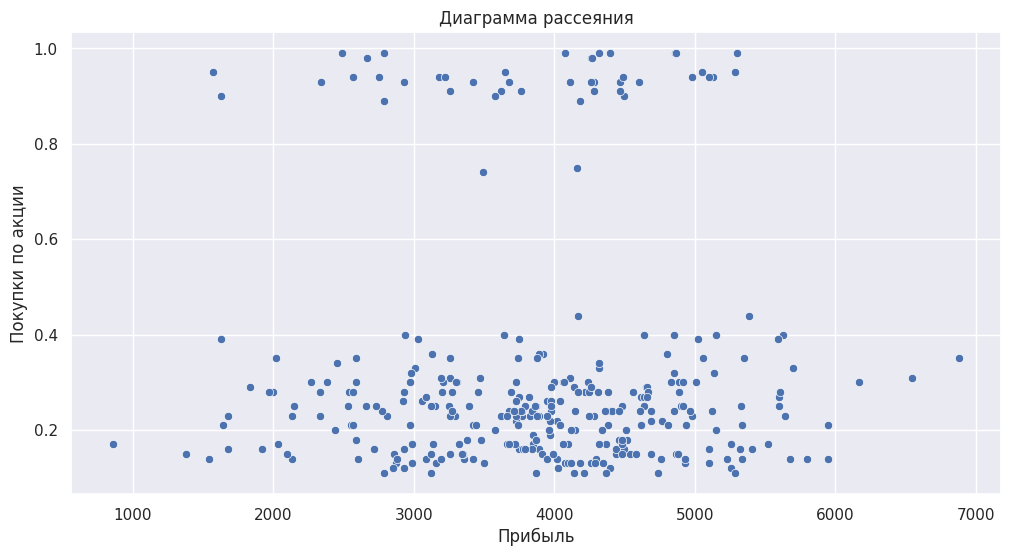

In [454]:
sns.scatterplot(data=X_test,
                    x='прибыль',
                    y='акционные_покупки')

plt.xlabel('Прибыль')
plt.ylabel('Покупки по акции')
plt.title('Диаграмма рассеяния')
sns.set(rc={'figure.figsize':(12, 6)})
plt.show()

На диаграмме рессеяния прибыль распределена равномерно. На графике видно как делятся покупки по акции, максимальным значением покупок по акции будем считать порог больше 0.9.

Построим диаграмму рассеяния по признакам `прибыль` и `вероятность`.

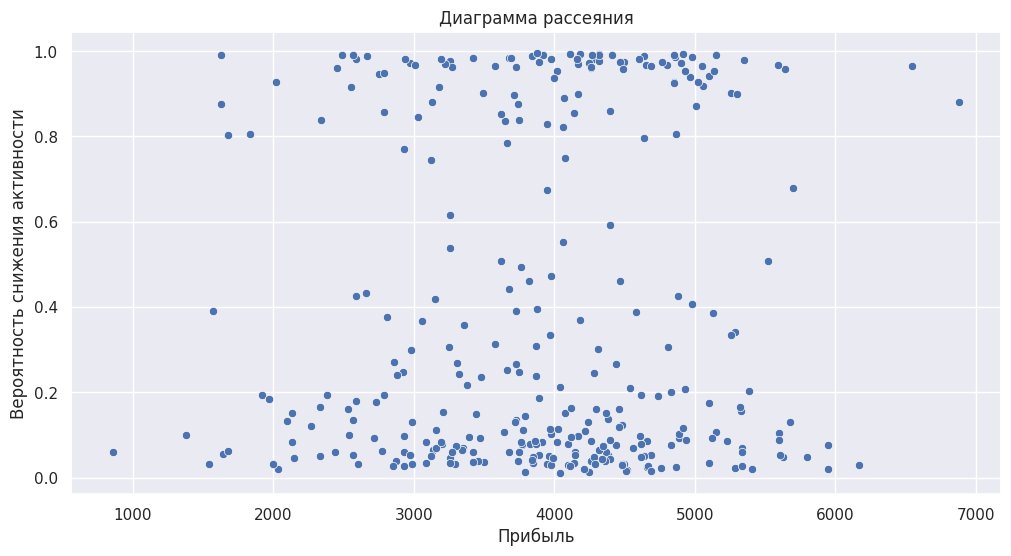

In [455]:
sns.scatterplot(data=X_test,
                    x='прибыль',
                    y='вероятность')

plt.xlabel('Прибыль')
plt.ylabel('Вероятность снижения активности')
plt.title('Диаграмма рассеяния')
sns.set(rc={'figure.figsize':(12, 6)})
plt.show()

На диаграмме рессеяния прибыль распределена равномерно, на графике видно деление вероятности снижения активности, высокой вероятностью будем считать порог больше 0.8.

Выделим сегмент покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

In [456]:
X_test['сегмент'] = \
X_test.apply(lambda x: 1 if (x['акционные_покупки'] > 0.9) & (x['вероятность'] > 0.8) else 0, axis=1)

Проверим сколько получилось клиентов в каждой категории.

In [457]:
X_test[X_test['сегмент'] == 1].shape

(27, 22)

In [458]:
X_test[X_test['сегмент'] == 0].shape

(297, 22)

Количество клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности составляет 27, остальные клиенты 297. Доля клиентов первого сегманта составляет примерно 9%.

Напишем функцию для проверки количественных значений.

In [459]:
def box_segment(col, bins='auto'):

    fig, axs = plt.subplots(ncols=2, figsize=(18, 8))

    (sns.histplot(data = X_test, x = col, hue = 'сегмент', bins = bins, ax = axs[0])
     .set(title=f'Распределение признака {col}', xlabel='Наблюдаемые значения', ylabel='Частота встречаемости'))


    (sns.boxplot(data = X_test, y =col, x='сегмент', showfliers=False, showmeans=True, ax=axs[1])
        .set(title = f'Зависимость сегмента от {col}\nТреугольник показывает среднее значение',
             xlabel = 'Сегмент', ylabel = 'Наблюдаемые значения'))
    plt.show()

    print('Описание данных сегмента 0:')
    print(X_test[X_test['сегмент'] == 0][col].describe())
    print('___________________________\n')
    print('Описание данных сегмента 1:')
    print(X_test[X_test['сегмент'] == 1][col].describe())

Напишем функцию для проверки категориальных значений.

In [460]:
def pie_segment(col, figsize=(14, 8)):
    pivot = X_test.pivot_table(index=col, columns='сегмент', values='ошибка_сервиса', aggfunc='count')
    pivot.columns = ['Сегмент 0', 'Сегмент 1']
    colors = sns.color_palette('pastel')[0:6]

    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    pivot['Сегмент 0'].plot(kind='pie', ax=axes[0], autopct='%1.2f%%', label='', colors=colors)
    axes[0].set_title(f'Процентное соотношение сегмента 0\nпо признаку {col}', fontsize=14)

    pivot['Сегмент 1'].plot(kind='pie', ax=axes[1], autopct='%1.2f%%', label='', colors=colors)
    axes[1].set_title(f'Процентное соотношение сегмента 1\nпо признаку {col}', fontsize=14)

    plt.show()

#### Проведем анализ данных клиентов сегмента 1 - с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности и остальных клиентов - сегмента 0.

##### Изучим количественные признаки.

Построим гистограмму распределения по признаку `прибыль`.

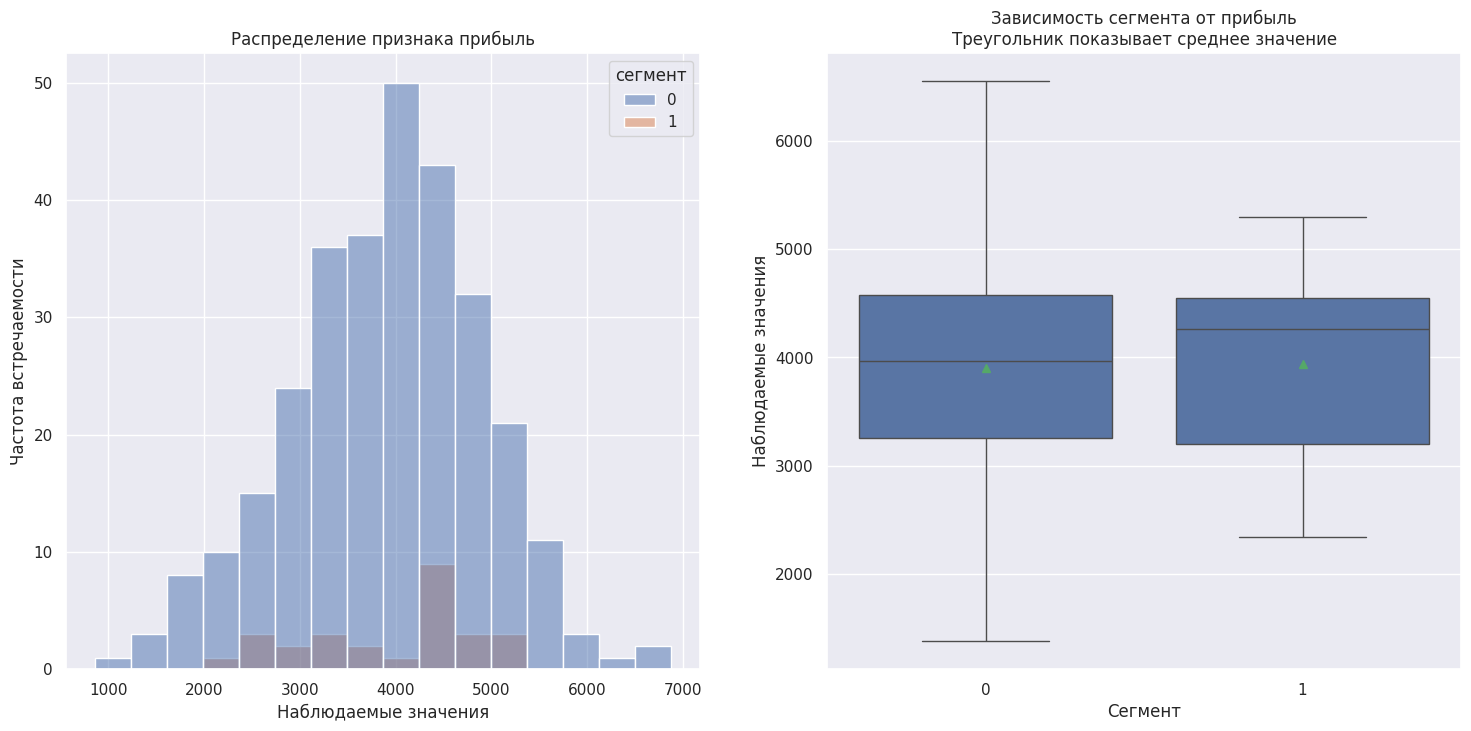

Описание данных сегмента 0:
count     297.000
mean    3,904.478
std     1,006.466
min       860.000
25%     3,260.000
50%     3,970.000
75%     4,580.000
max     6,880.000
Name: прибыль, dtype: float64
___________________________

Описание данных сегмента 1:
count      27.000
mean    3,940.000
std       908.558
min     2,340.000
25%     3,200.000
50%     4,260.000
75%     4,545.000
max     5,300.000
Name: прибыль, dtype: float64


In [461]:
box_segment('прибыль')

Среднее значние прибыли и квартили в обоих сегмантах примерно одинаковы, отличаются только минимальные и максимальные значения прибыли. Размах значений сегмента 0 от 860 до 6,880, медиана 3,970. Размах значений сегмента 1 от 2,340 до 5,300, медиана 4,260.

Построим гистограмму распределения по признаку `средний_просмотр_категорий_за_визит`.

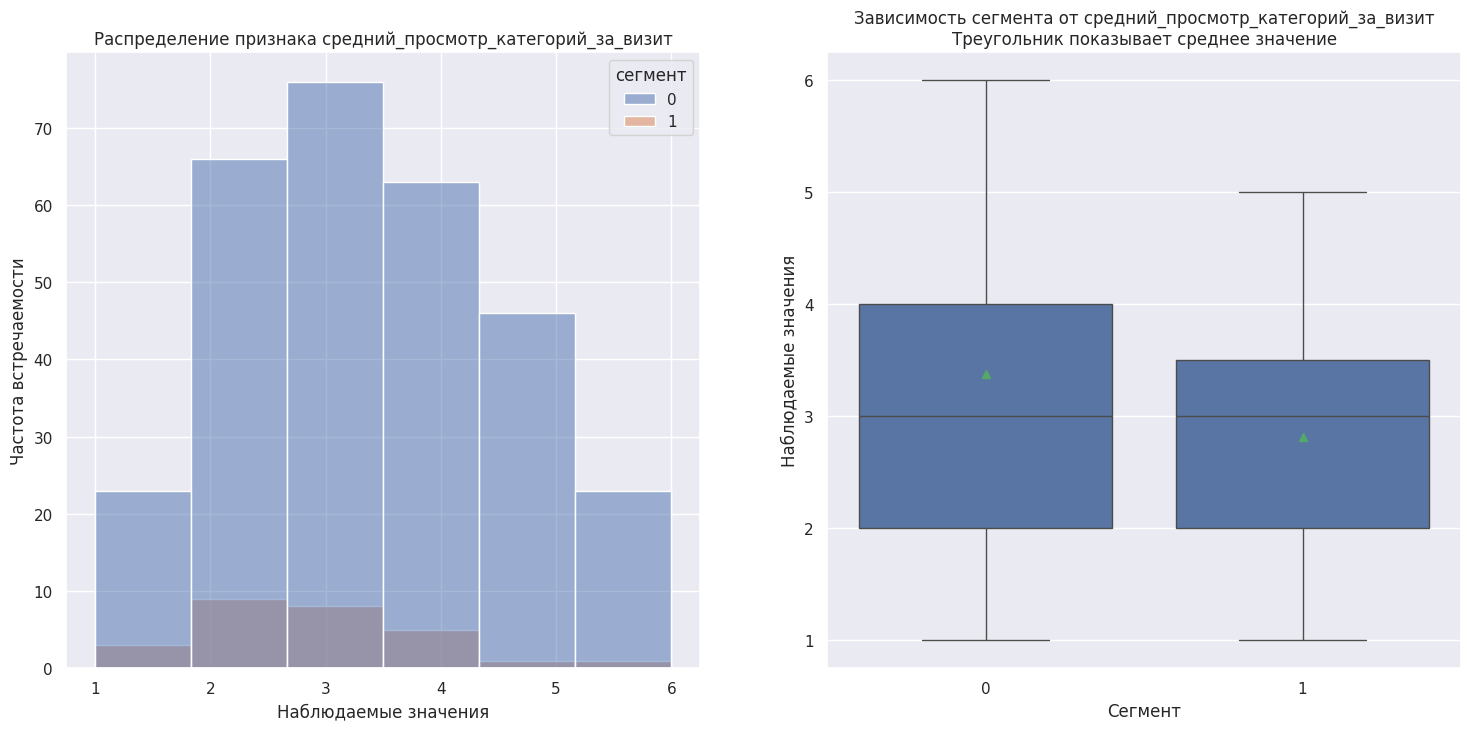

Описание данных сегмента 0:
count   297.000
mean      3.377
std       1.387
min       1.000
25%       2.000
50%       3.000
75%       4.000
max       6.000
Name: средний_просмотр_категорий_за_визит, dtype: float64
___________________________

Описание данных сегмента 1:
count   27.000
mean     2.815
std      1.210
min      1.000
25%      2.000
50%      3.000
75%      3.500
max      6.000
Name: средний_просмотр_категорий_за_визит, dtype: float64


In [462]:
box_segment('средний_просмотр_категорий_за_визит', bins=6)

Средний просмотр категой в обоих сегментах составляют от 1 до 6 категорий. В обоих сегментах самые высокие значения 2, 3 и 4 категории за визит, однако, 5 и 6 категорий в большей степени принадлежат сегменту 0, то есть клиентам, по которым не спрогнозировано снижение активности.

Построим гистограмму распределения по признаку `неоплаченные_продукты_штук_квартал`.

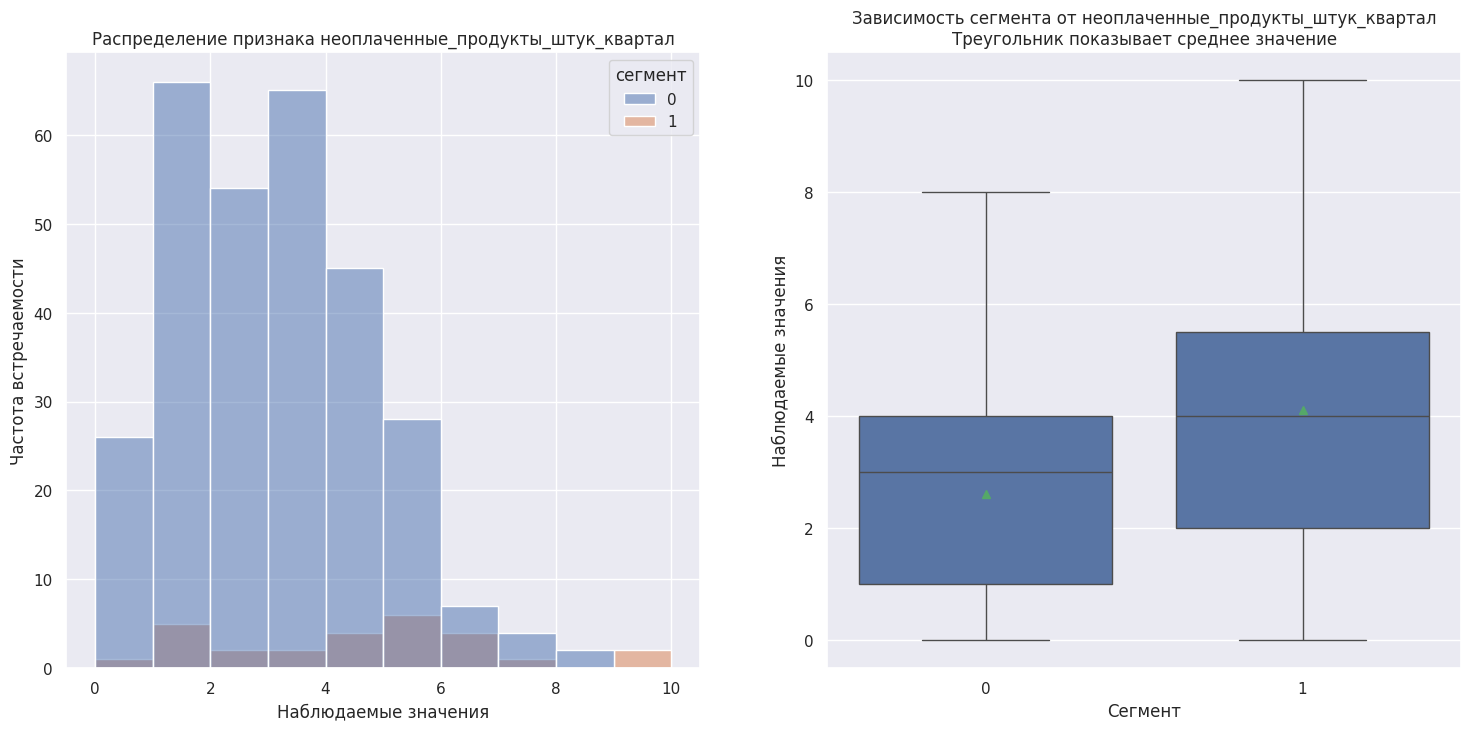

Описание данных сегмента 0:
count   297.000
mean      2.609
std       1.685
min       0.000
25%       1.000
50%       3.000
75%       4.000
max       8.000
Name: неоплаченные_продукты_штук_квартал, dtype: float64
___________________________

Описание данных сегмента 1:
count   27.000
mean     4.111
std      2.501
min      0.000
25%      2.000
50%      4.000
75%      5.500
max     10.000
Name: неоплаченные_продукты_штук_квартал, dtype: float64


In [463]:
box_segment('неоплаченные_продукты_штук_квартал', bins=10)

В сегменте 1, то есть в сегменте, по которому спрогнозировано снижение активности и максимальной долей покупок по акции, неоплаченных продуктов больше, чем в сегменте 0. Разброс значений в сегменте 0 составляет от 0 до 8, в сегменте 1 от 0 до 10. Среднее значение и медиана в с сегменте 0 составляет 2.6 и 3, в сегменте 1 - 2.5 и 4. Можно предположить, что клиенты, которые чаще не оплачивают заказы могут в дальнейшем снизить покупательскую активность.

Построим гистограмму распределения по признаку `ошибка_сервиса`.

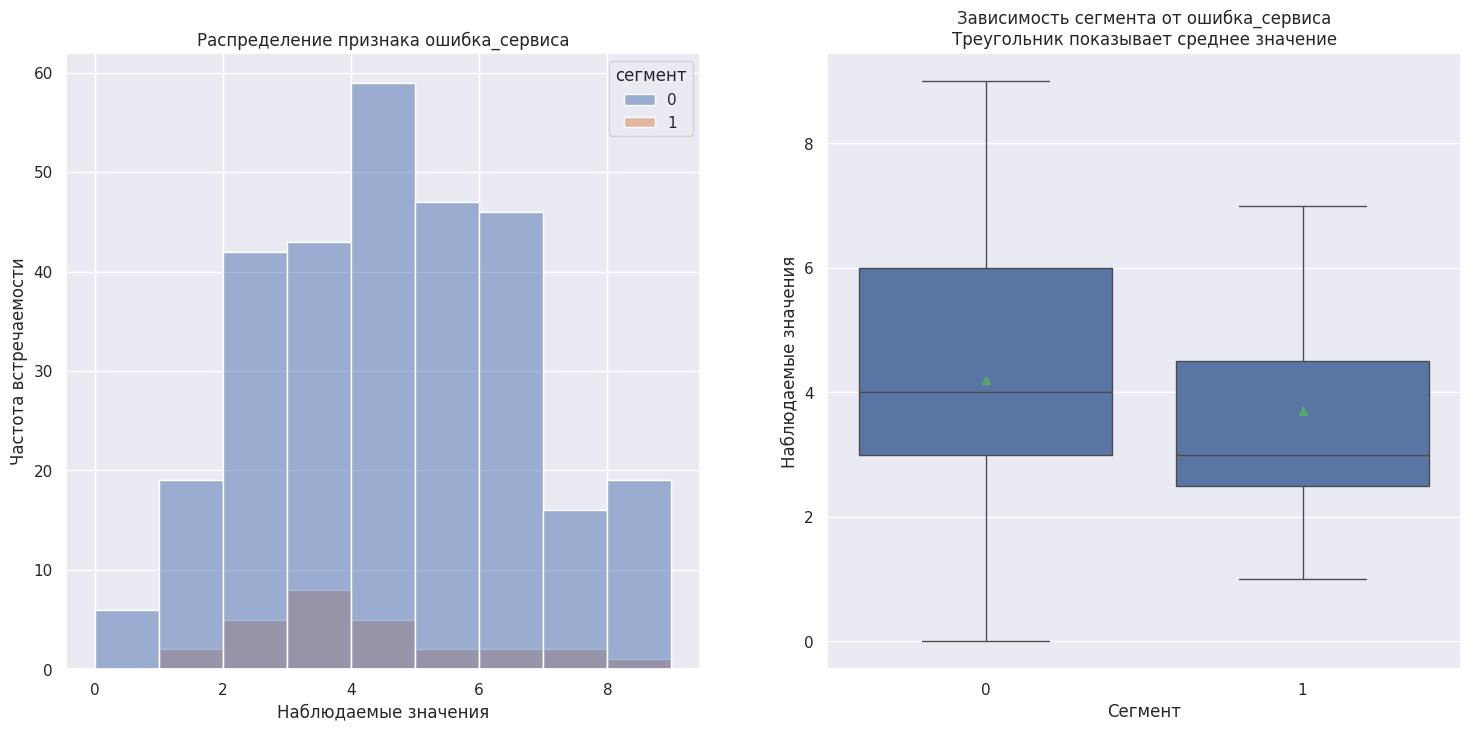

Описание данных сегмента 0:
count   297.000
mean      4.199
std       1.998
min       0.000
25%       3.000
50%       4.000
75%       6.000
max       9.000
Name: ошибка_сервиса, dtype: float64
___________________________

Описание данных сегмента 1:
count   27.000
mean     3.704
std      1.836
min      1.000
25%      2.500
50%      3.000
75%      4.500
max      8.000
Name: ошибка_сервиса, dtype: float64


In [464]:
box_segment('ошибка_сервиса', bins=9)

Судя по графику, ошибка сервиса почти не повлияла на сегмент 1, в среднем в данном сегменте ошибка составляет 3.7, в сегменте 0 - 4.2.

Построим гистограмму распределения по признаку `страниц_за_визит`.

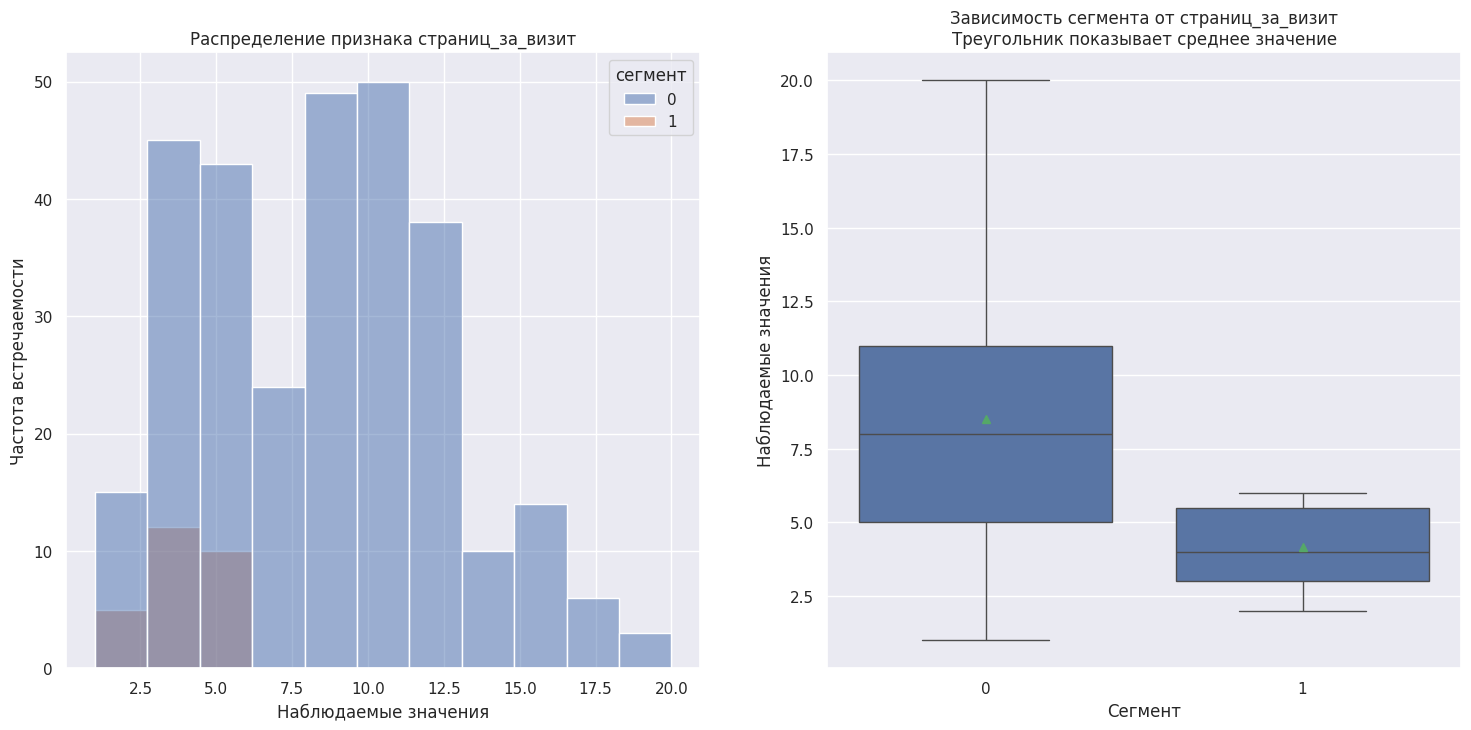

Описание данных сегмента 0:
count   297.000
mean      8.508
std       4.025
min       1.000
25%       5.000
50%       8.000
75%      11.000
max      20.000
Name: страниц_за_визит, dtype: float64
___________________________

Описание данных сегмента 1:
count   27.000
mean     4.148
std      1.433
min      2.000
25%      3.000
50%      4.000
75%      5.500
max      6.000
Name: страниц_за_визит, dtype: float64


In [465]:
box_segment('страниц_за_визит')

Первый сегмент клиентов просматривают меньше страниц за визит, медиана и среднее значение составляют 4.1 и 4, сегмента ноль - 8.5 и 8. Разброс значений первого сегмента от 2 до 6, нулевого - от 1 до 20. Можно предположить, что клиенты, которые просматривают больше страниц, с большей вероятностью не снизят покупательскую активность.

Построим гистограмму распределения по признаку `выручка_предыдущий_месяц`.

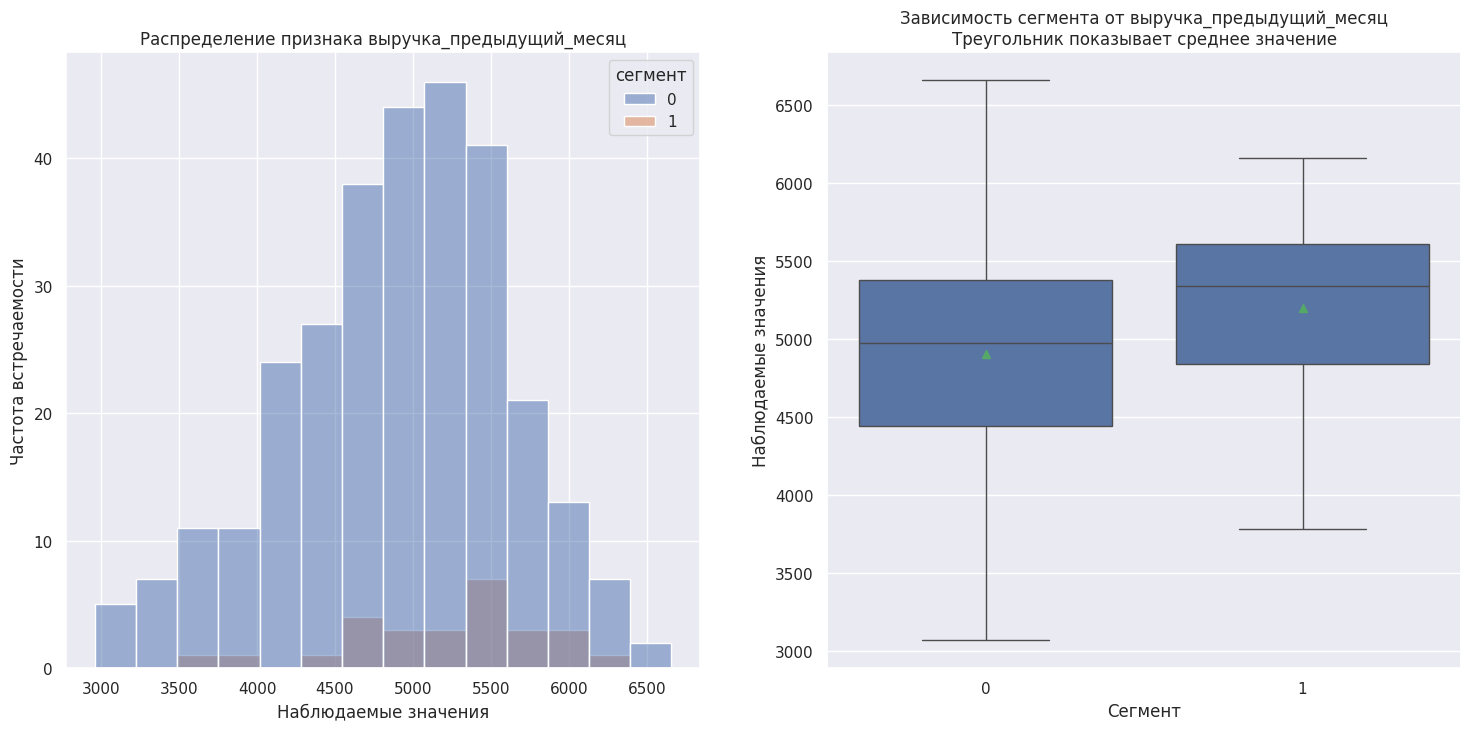

Описание данных сегмента 0:
count     297.000
mean    4,899.833
std       707.067
min     2,960.000
25%     4,438.000
50%     4,971.000
75%     5,379.500
max     6,658.500
Name: выручка_предыдущий_месяц, dtype: float64
___________________________

Описание данных сегмента 1:
count      27.000
mean    5,197.426
std       644.109
min     3,548.000
25%     4,840.000
50%     5,339.000
75%     5,611.000
max     6,158.000
Name: выручка_предыдущий_месяц, dtype: float64


In [466]:
box_segment('выручка_предыдущий_месяц')

Разброс значений выручки за предыдущий месяц у сегмента 0 составляет от 2,960 до 6,658, сегмента 1 - от 3,548 до 6,158. Серднее значение и медиана сегмента 0 составляет 4,899 и 4,971, сегмента 1 - 5,197 и 5,339. Клиенты сегмента 1 в среднем принесли большую выручку за предыдущий месяц, можно предположить, что клиенты перед снижением активности покупают товары на большую сумму.

Построим гистограмму распределения по признаку `выручка_препредыдущий_месяц`.

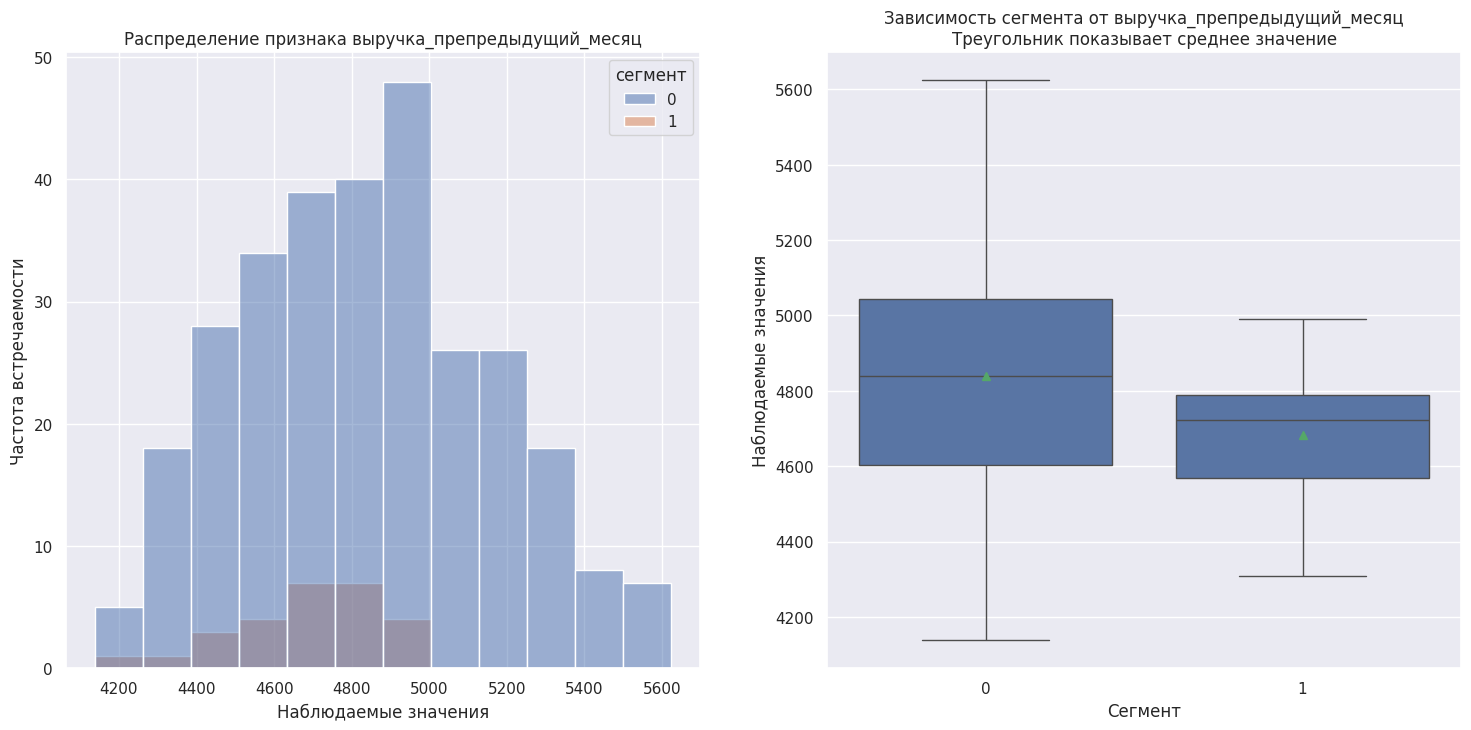

Описание данных сегмента 0:
count     297.000
mean    4,839.741
std       321.621
min     4,138.000
25%     4,604.000
50%     4,840.000
75%     5,043.000
max     5,624.000
Name: выручка_препредыдущий_месяц, dtype: float64
___________________________

Описание данных сегмента 1:
count      27.000
mean    4,683.630
std       195.296
min     4,190.000
25%     4,568.500
50%     4,723.000
75%     4,787.500
max     4,990.000
Name: выручка_препредыдущий_месяц, dtype: float64


In [467]:
box_segment('выручка_препредыдущий_месяц')

Разброс значений выручки за препредыдущий месяц у сегмента 0 составляет от 4,138 до 5,624, сегмента 1 - от 4,190 до 4,990. Серднее значение и медиана сегмента 0 составляет 4,839 и 4,840, сегмента 1 - 4,683 и 4,840. Клиенты сегмента 1 в среднем принесли большую выручку за препредыдущий месяц.

Построим гистограмму распределения по признаку `выручка_текущий_месяц`.

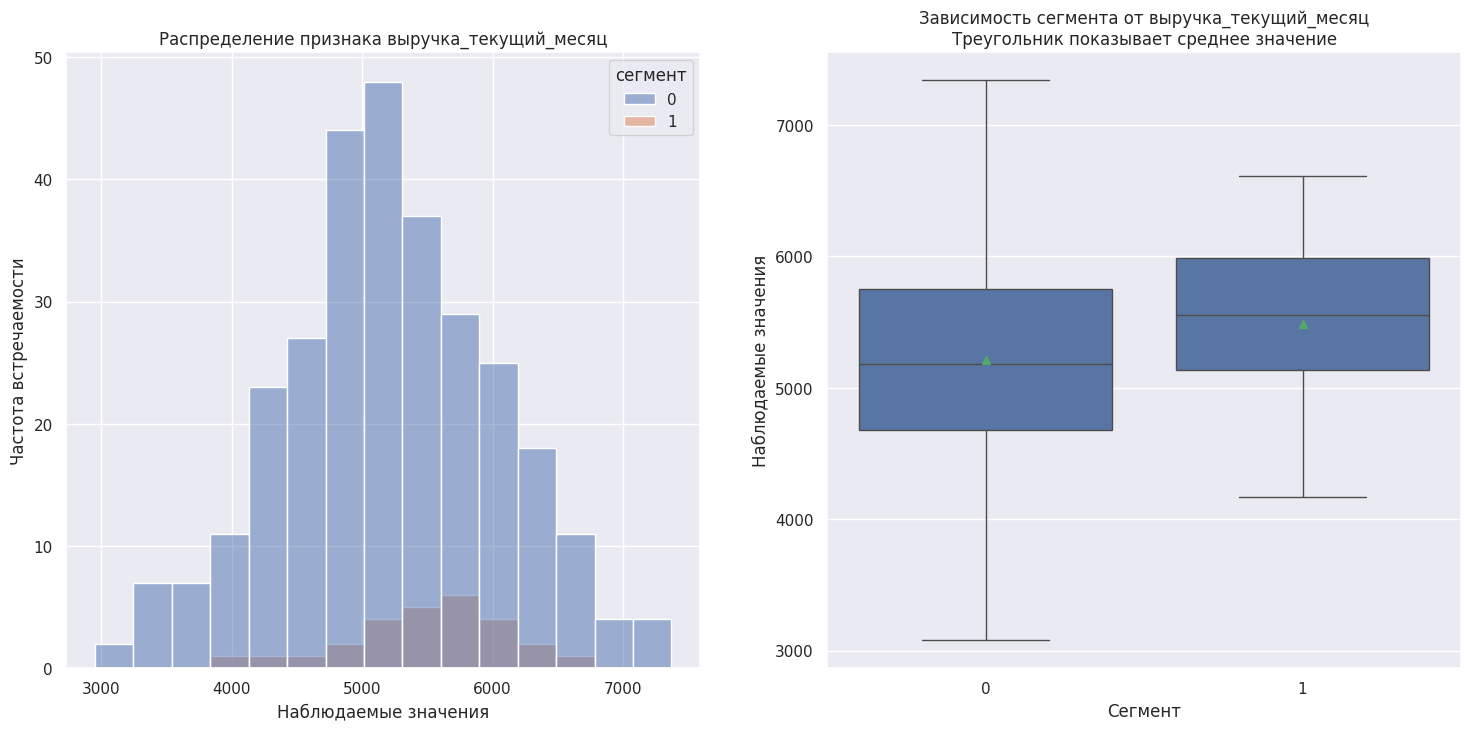

Описание данных сегмента 0:
count     297.000
mean    5,211.636
std       825.417
min     2,952.200
25%     4,681.400
50%     5,182.900
75%     5,750.400
max     7,370.600
Name: выручка_текущий_месяц, dtype: float64
___________________________

Описание данных сегмента 1:
count      27.000
mean    5,484.244
std       662.291
min     3,848.000
25%     5,132.750
50%     5,549.700
75%     5,983.350
max     6,610.400
Name: выручка_текущий_месяц, dtype: float64


In [468]:
box_segment('выручка_текущий_месяц')

Разброс значений выручки за текущий месяц у сегмента 0 составляет от 2,952 до 7,370, сегмента 1 - от 3,848 до 6,610. Серднее значение и медиана сегмента 0 составляет 5,211 и 5,182, сегмента 1 - 5,484 и 5,549. Клиенты сегмента 1 в среднем принесли большую выручку за текущий месяц.

Построим гистограмму распределения по признаку `время_предыдущий_месяц`.

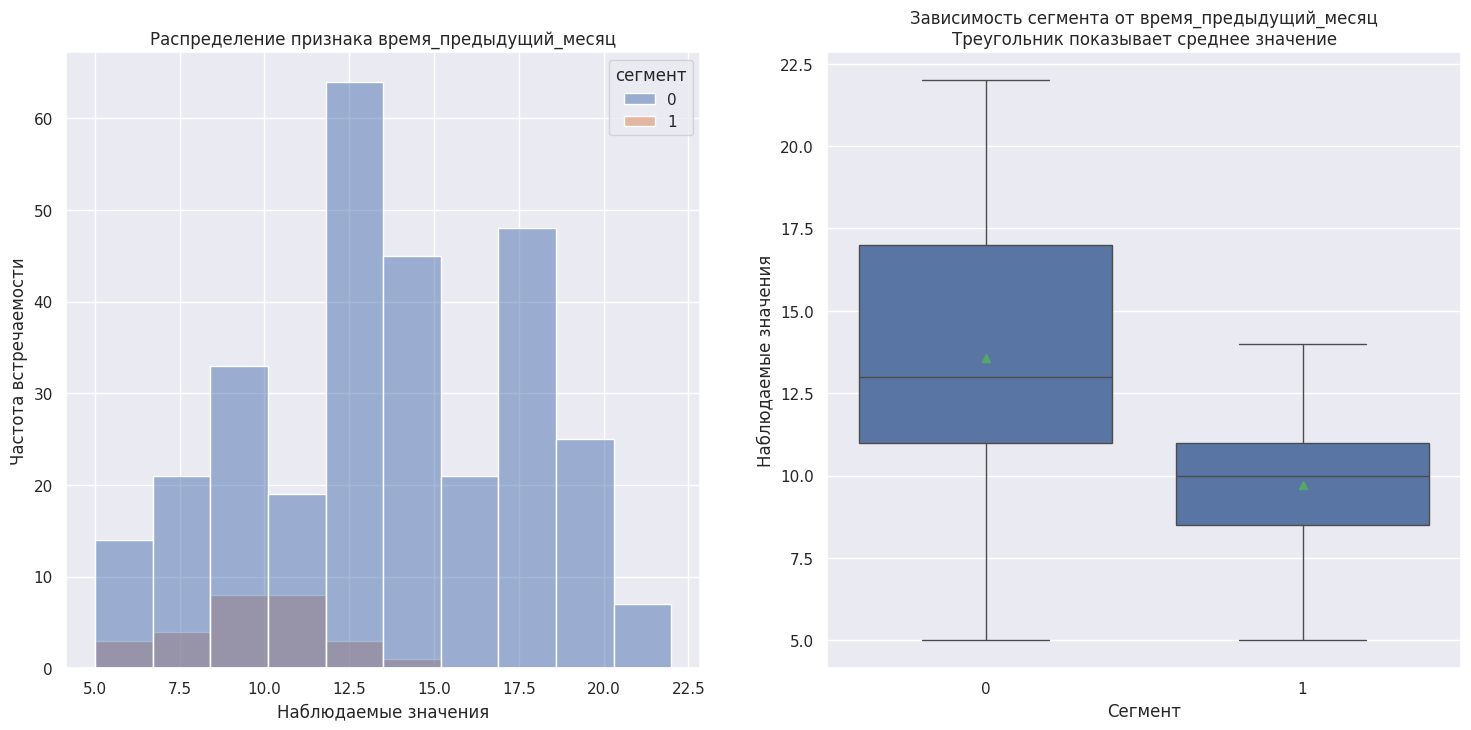

Описание данных сегмента 0:
count   297.000
mean     13.566
std       3.916
min       5.000
25%      11.000
50%      13.000
75%      17.000
max      22.000
Name: время_предыдущий_месяц, dtype: float64
___________________________

Описание данных сегмента 1:
count   27.000
mean     9.704
std      2.163
min      5.000
25%      8.500
50%     10.000
75%     11.000
max     14.000
Name: время_предыдущий_месяц, dtype: float64


In [469]:
box_segment('время_предыдущий_месяц')

На графике мы видим, что клиенты сегмента 0 провесли на сайте в предыдущем месяце больше времени.

Построим гистограмму распределения по признаку `время_текущий_месяц`.

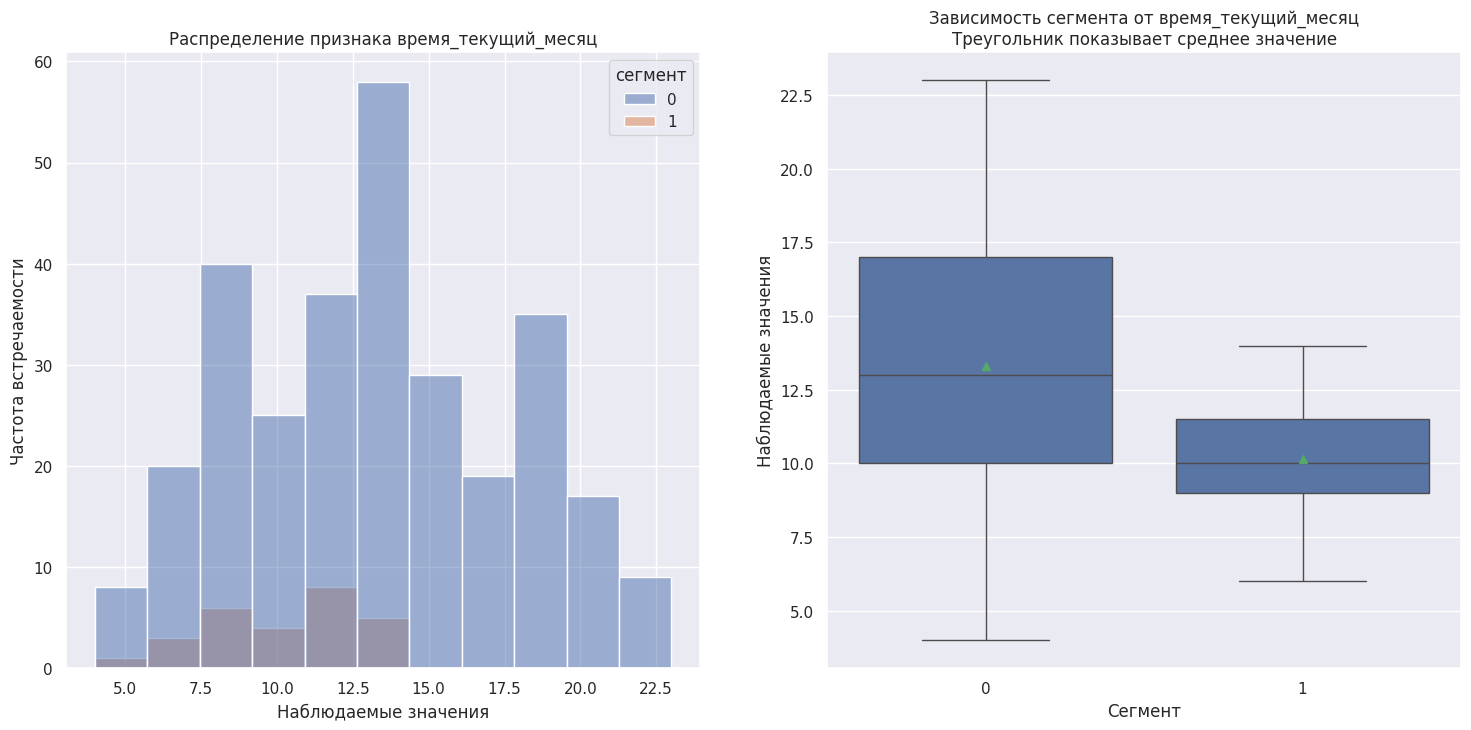

Описание данных сегмента 0:
count   297.000
mean     13.293
std       4.426
min       4.000
25%      10.000
50%      13.000
75%      17.000
max      23.000
Name: время_текущий_месяц, dtype: float64
___________________________

Описание данных сегмента 1:
count   27.000
mean    10.148
std      2.265
min      5.000
25%      9.000
50%     10.000
75%     11.500
max     14.000
Name: время_текущий_месяц, dtype: float64


In [470]:
box_segment('время_текущий_месяц')

На графике мы видим, что клиенты сегмента 0 провесли на сайте в текущем месяце больше времени.

##### Изучим категориальные признаки.

Построим круговую диаграмму по признаку `тип_сервиса`.

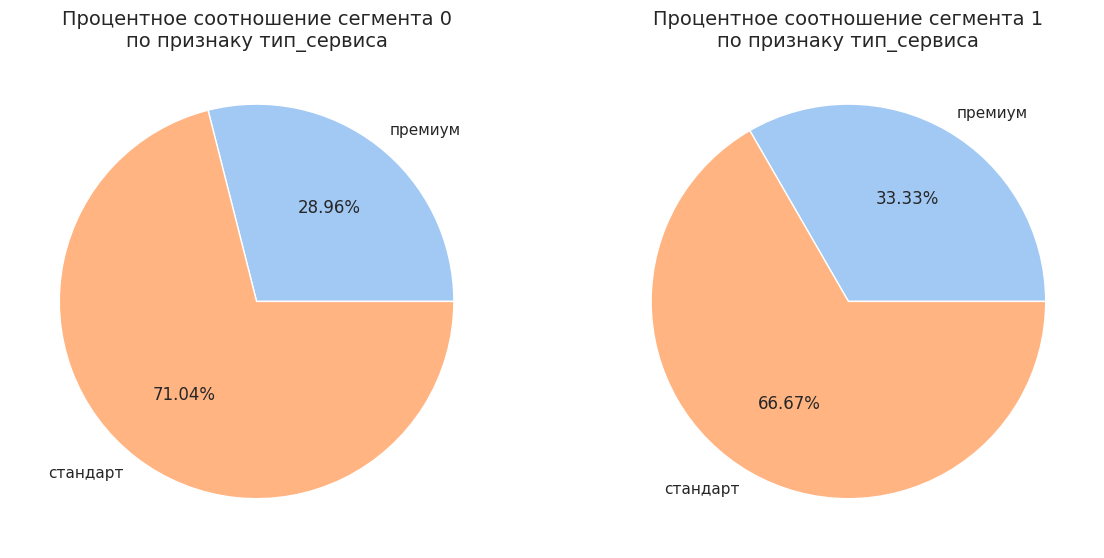

In [471]:
pie_segment('тип_сервиса')

Тип сервиса стандарт в сегменте 0 составляет примерно 71%, премиум - 29%. В сегменте 1 тип сервиса стандарт - 67%, премиум 33%.

Построим круговую диаграмму по признаку `разрешить_сообщать`.

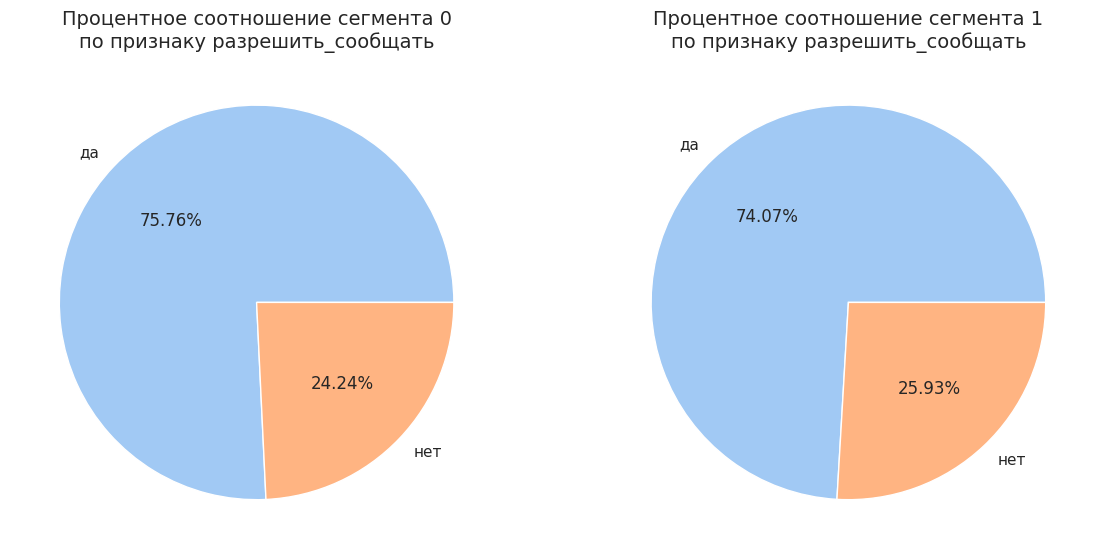

In [472]:
pie_segment('разрешить_сообщать')

Разрешение на информационную рассылку в сегментах почти одинаковое, 75% дали согласие на рассылку, 25% не дали.

Построим круговую диаграмму по признаку `популярная_категория`.

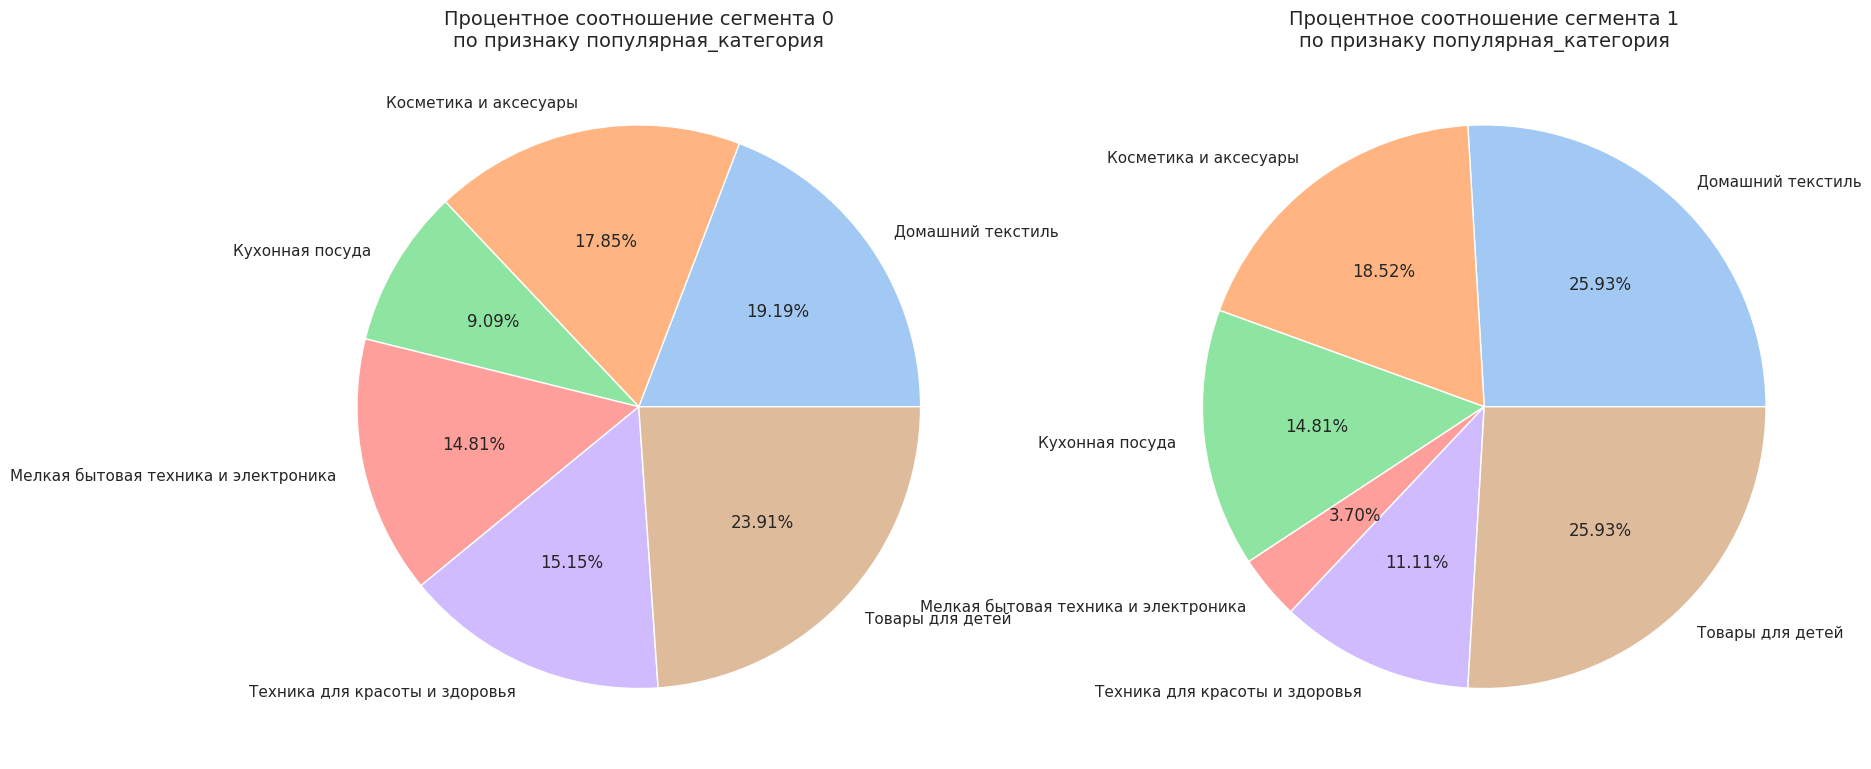

In [473]:
pie_segment('популярная_категория', figsize=(20, 12))

В обоих сегментах наиболее популярные категории `Товары для детей`, `Домашний текстиль` и `Косметика и аксесуары`.

#### Выводы.

Средний просмотр категой в обоих сегментах составляют от 1 до 6 категорий. В обоих сегментах самые высокие значения 2, 3 и 4 категории за визит, однако, 5 и 6 категорий в большей степени принадлежат сегменту 0, то есть клиентам, по которым не спрогнозировано снижение активности.

В сегменте 1, то есть в сегменте, по которому спрогнозировано снижение активности и максимальной долей покупок по акции, неоплаченных продуктов больше, чем в сегменте 0. Разброс значений в сегменте 0 составляет от 0 до 8, в сегменте 1 от 0 до 10. Среднее значение и медиана в с сегменте 0 составляет 2.6 и 3, в сегменте 1 - 2.5 и 4. Можно предположить, что клиенты, которые чаще не оплачивают заказы могут в дальнейшем снизить покупательскую активность.

Ошибка сервиса почти не повлияла на сегмент 1, в среднем в данном сегменте ошибка составляет 3.7, в сегменте 0 - 4.2.

Первый сегмент клиентов просматривают меньше страниц за визит, медиана и среднее значение составляют 4.1 и 4, сегмента ноль - 8.5 и 8. Разброс значений первого сегмента от 2 до 6, нулевого - от 1 до 20. Можно предположить, что клиенты, которые просматривают больше страниц, с большей вероятностью не снизят покупательскую активность.

Разброс значений выручки за предыдущий месяц у сегмента 0 составляет от 2,960 до 6,658, сегмента 1 - от 3,548 до 6,158. Серднее значение и медиана сегмента 0 составляет 4,899 и 4,971, сегмента 1 - 5,197 и 5,339. Клиенты сегмента 1 в среднем принесли большую выручку за предыдущий месяц, можно предположить, что клиенты перед снижением активности покупают товары на большую сумму.

Разброс значений выручки за препредыдущий месяц у сегмента 0 составляет от 4,138 до 5,624, сегмента 1 - от 4,190 до 4,990. Серднее значение и медиана сегмента 0 составляет 4,839 и 4,840, сегмента 1 - 4,683 и 4,840. Клиенты сегмента 1 в среднем принесли большую выручку за препредыдущий месяц.

Разброс значений выручки за текущий месяц у сегмента 0 составляет от 2,952 до 7,370, сегмента 1 - от 3,848 до 6,610. Серднее значение и медиана сегмента 0 составляет 5,211 и 5,182, сегмента 1 - 5,484 и 5,549. Клиенты сегмента 1 в среднем принесли большую выручку за текущий месяц.

Клиенты сегмента 0 провесли на сайте в текущем и предыдущем месяце больше времени.

Тип сервиса стандарт в сегменте 0 составляет примерно 71%, премиум - 29%. В сегменте 1 тип сервиса стандарт - 67%, премиум 33%.

Разрешение на информационную рассылку в сегментах почти одинаковое, 75% дали согласие на рассылку, 25% не дали.

В обоих сегментах наиболее популярные категории `Товары для детей`, `Домашний текстиль` и `Косметика и аксесуары`.

### Общий вывод.

**Обзор данных.**

Данные в таблицах `market_file`, `market_money`, `market_time` и `money` предоставленны полностью. Столбцы `Маркет_актив_6_мес`, `Акционные_покупки` и `Выручка` необходимо привести к подходящему формату. Столбец `Прибыль` необходимо умножить на 1000.

**Предобработка данных.**

При изучении общей информации были выявлены и обработанны следующие данные:

- переименованы столбцы в таблицах `market_file`, `market_money`, `market_time`, `money`
- изучены пропущенные значения в таблицах `market_file`, `market_money`, `market_time`, `money`
- обработаны явные дубликаты в таблицах `market_file`, `market_money`, `market_time`, `money`
- выявлены и обработаны неявные дубликаты в таблице `market_file`
- изменены типы данных в таблицах `market_file`, `market_money`, `money`
- проверены количественные значения в таблицах `market_file`, `market_money`, `market_time`, `money`
- удален выброс в таблицах `market_file`, `market_money`, `market_time`, `money`

Данные в таблицах были предоставленны полностью, пропусков не обнаружено. Явных дубликатов не обнаружено, были выявлены и обработаны неявные дубликаты в таблице `market_file`. В таблицах `market_file`, `market_money`, `money` типы данных были приведены в соответствии значениям. Были проверены количественные значения в таблицах `market_file`, `market_money`, `market_time`, `money`. В таблице `market_money` был найден и удален выброс в столбце `выручка` со значением 106,862. Остальные данные выглядят нормально.

**Исследовательский анализ данных.**

В таблице `market_file` данные количественных признаков распределены нормально, выбросов обнаружено не было. Была вявлена небольшая группа клиентов с низкой маркетинговой активностью, меньше двух.  Распределение признака `акционные_покупки` деляться на 2 кластера. Основная доля покупок по акциям лежит в значениях от 11% до 40%. Есть группа клиентов, у которых 90% покупок состоят только из акционных товаров. Возможно стоит разделить клиентов на категории, с акционными покупками до 50% и более 50%.

Целевым признаком является `покупательская_активность`. Значений `Прежний уровень` примерно 62%, `Снизилась` примерно 38%. Первый признак выше, но не критично.

Больше пользователей с типом сервиса `стандарт` - 922, `премиум` - 374.

Большинство клиентов дали согласие на рассылку - 74% согласны, 26% отказались.

Наиболее популярная категория `Товары для детей`, заетм `Домашний текстиль` и `Косметика и аксесуары`. `Кухонная посуда` является наименее популярной категорией.

Данные в таблице `market_money`распределены нормально, выбросов не обнаружено. Разброс значений признака `выручка` - от 2758 до 7799.

Данные в таблице `market_time` распределены нормально. Разброс значений от 4 до 23. Выбросов не обнаружено.

Данные в таблице `money` также аспределены нормально. Разброс значений от 860 до 7430. Выбросов не обнаружено.

**Корреляционный анализ данных.**

На матрице мы обнаружили, что `Покупательская активность` коррелирует со всеми признаками, кроме `маркет_актив_тек_мес` и `разрешить_сообщать`.

Корреляция между признаками недостатачно высокая, чтобы говорить о мультиколлинеарности.

**Использование пайплайнов.**

Для поиска лучшей модели был использован метод GridSearchCV. Он создаёт отдельную модель для каждой комбинации настроек, обучает её и считает метрику при кросс-валидации.

Лучшая модель - SVC, с параметрами C=0.1, gamma=0.1, с кодировщиком StandardScaler.

Метрика roc_auc лучшей модели на кросс-валидационной и тестовой выборке составила 0.91. ROC-AUC оценивает качество решений модели в наиболее общем виде, учитывая все возможные пороговые значения.

**Анализ важности признаков.**

Наиболее важные признаки: `страниц_за_визит`, `время_предыдущий_месяц`, `время_текущий_месяц`, `акционные_покупки` и `средний_просмотр_категорий_за_визит`.

Мало важные признаки: `популярная_категория_Техника для красоты и здоровья`, `разрешить_сообщать_нет`, `популярная_категория_Кухонная посуда`, `популярная_категория_Мелкая бытовая техника и электроника` и `тип_сервиса`.

Категории товаров оказались не столь важны. На покупательскую активность больше влияет количество просмотренных страниц, время проведенное на сайте и акционные покупки. Исходя из данных наблюдений, можно сделать вывод, что нужно создавать условия на сайте для максимально комфортного просмотра товаров и следить за наличием акций.

**Сегментация покупателей.**

Среднее значние прибыли и квартили в обоих сегмантах примерно одинаковы, отличаются только минимальные и максимальные значения прибыли. Размах значений сегмента 0 от 860 до 6,880, медиана 3,970. Размах значений сегмента 1 от 2,340 до 5,300, медиана 4,260.

Средний просмотр категой в обоих сегментах составляют от 1 до 6 категорий. В обоих сегментах самые высокие значения 2, 3 и 4 категории за визит, однако, 5 и 6 категорий в большей степени принадлежат сегменту 0, то есть клиентам, по которым не спрогнозировано снижение активности.

В сегменте 1, то есть в сегменте, по которому спрогнозировано снижение активности и максимальной долей покупок по акции, неоплаченных продуктов больше, чем в сегменте 0. Разброс значений в сегменте 0 составляет от 0 до 8, в сегменте 1 от 0 до 10. Среднее значение и медиана в с сегменте 0 составляет 2.6 и 3, в сегменте 1 - 2.5 и 4. Можно предположить, что клиенты, которые чаще не оплачивают заказы могут в дальнейшем снизить покупательскую активность.

Ошибка сервиса почти не повлияла на сегмент 1, в среднем в данном сегменте ошибка составляет 3.7, в сегменте 0 - 4.2.

Первый сегмент клиентов просматривают меньше страниц за визит, медиана и среднее значение составляют 4.1 и 4, сегмента ноль - 8.5 и 8. Разброс значений первого сегмента от 2 до 6, нулевого - от 1 до 20. Можно предположить, что клиенты, которые просматривают больше страниц, с большей вероятностью не снизят покупательскую активность.

Разброс значений выручки за предыдущий месяц у сегмента 0 составляет от 2,960 до 6,658, сегмента 1 - от 3,548 до 6,158. Серднее значение и медиана сегмента 0 составляет 4,899 и 4,971, сегмента 1 - 5,197 и 5,339. Клиенты сегмента 1 в среднем принесли большую выручку за предыдущий месяц, можно предположить, что клиенты перед снижением активности покупают товары на большую сумму.

Разброс значений выручки за препредыдущий месяц у сегмента 0 составляет от 4,138 до 5,624, сегмента 1 - от 4,190 до 4,990. Серднее значение и медиана сегмента 0 составляет 4,839 и 4,840, сегмента 1 - 4,683 и 4,840. Клиенты сегмента 1 в среднем принесли большую выручку за препредыдущий месяц.

Разброс значений выручки за текущий месяц у сегмента 0 составляет от 2,952 до 7,370, сегмента 1 - от 3,848 до 6,610. Серднее значение и медиана сегмента 0 составляет 5,211 и 5,182, сегмента 1 - 5,484 и 5,549. Клиенты сегмента 1 в среднем принесли большую выручку за текущий месяц.

Клиенты сегмента 0 провесли на сайте в текущем и предыдущем месяце больше времени.

Тип сервиса стандарт в сегменте 0 составляет примерно 71%, премиум - 29%. В сегменте 1 тип сервиса стандарт - 67%, премиум 33%.

Разрешение на информационную рассылку в сегментах почти одинаковое, 75% дали согласие на рассылку, 25% не дали.

В обоих сегментах наиболее популярные категории `Товары для детей`, `Домашний текстиль` и `Косметика и аксесуары`.